# Mantenimiento Predictivo de Turbinas

Durante la vida útil de las turbinas, estas sufren desgaste, que impacta directamente en su confiabilidad y performance.
Esta notebook es para crear un modelo reutilizable, que en este caso es para predecir la vida util restante (RUL: remaining useful life) de turbinas, basado en data sobre el ciclo de vida completo de las mismas para planificar mejor su mantenimiento.

<img src='_src/turbofan-operation-lbp.png'>

In [80]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost
#import tensorflow as tf


#import sklearn
from sklearn.metrics import mean_squared_error, r2_score
#import os

import random
np.random.seed(137)

import warnings
warnings.filterwarnings('ignore')

# venv/Scripts/Activate.ps1

---

#### Definimos nombres de variables

In [81]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i+1}' for i in range(0, 21)]
col_names = index_names + setting_names + sensor_names

#### Importamos la data de entrenamiento y de validación.

El dataset FD001 corresponde a una falla HPC de la turbina.

In [82]:
dftrain = pd.read_csv('_data/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv('_data/test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
y_valid = pd.read_csv('_data/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])
dfvalid.shape

(13096, 26)

In [83]:
train = dftrain.copy()
valid = dfvalid.copy()

### Exploración de datos

In [84]:
train

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1  \
0                1            1    -0.0007    -0.0004      100.0  518.67   
1                1            2     0.0019    -0.0003      100.0  518.67   
2                1            3    -0.0043     0.0003      100.0  518.67   
3                1            4     0.0007     0.0000      100.0  518.67   
4                1            5    -0.0019    -0.0002      100.0  518.67   
...            ...          ...        ...        ...        ...     ...   
20626          100          196    -0.0004    -0.0003      100.0  518.67   
20627          100          197    -0.0016    -0.0005      100.0  518.67   
20628          100          198     0.0004     0.0000      100.0  518.67   
20629          100          199    -0.0011     0.0003      100.0  518.67   
20630          100          200    -0.0032    -0.0005      100.0  518.67   

          s_2      s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  \
0      641.82  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195   
1      642.15  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318   
2      642.35  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178   
3      642.35  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682   
4      642.37  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294   
...       ...      ...      ...    ...  ...     ...      ...      ...     ...   
20626  643.49  1597.98  1428.63  14.62  ...  519.49  2388.26  8137.60  8.4956   
20627  643.54  1604.50  1433.58  14.62  ...  519.68  2388.22  8136.50  8.5139   
20628  643.42  1602.46  1428.18  14.62  ...  520.01  2388.24  8141.05  8.5646   
20629  643.23  1605.26  1426.53  14.62  ...  519.67  2388.23  8139.29  8.5389   
20630  643.85  1600.38  1432.14  14.62  ...  519.30  2388.26  8137.33  8.5036   

       s_16  s_17  s_18   s_19   s_20     s_21  
0      0.03   392  2388  100.0  39.06  23.4190  
1      0.03   392  2388  100.0  39.00  23.4236  
2      0.03   390  2388  100.0  38.95  23.3442  
3      0.03   392  2388  100.0  38.88  23.3739  
4      0.03   393  2388  100.0  38.90  23.4044  
...     ...   ...   ...    ...    ...      ...  
20626  0.03   397  2388  100.0  38.49  22.9735  
20627  0.03   395  2388  100.0  38.30  23.1594  
20628  0.03   398  2388  100.0  38.44  22.9333  
20629  0.03   395  2388  100.0  38.29  23.0640  
20630  0.03   396  2388  100.0  38.37  23.0522  

[20631 rows x 26 columns]

El dataset FD001 contiene series de tiempo de 21 sensores y 3 configuraciones de 100 turbinas.

Cada turbina trabaja normalmente al comienzo de cada serie de tiempo y falla al final.

Cada fila es una medida tomada durante un solo ciclo de funcionamiento.

In [85]:
print('Forma del set de entrenamiento: ', train.shape)
print('Forma del set de validación: ',valid.shape)
print('Porcentaje del set de validación: ',len(valid)/(len(valid)+len(train)))

Forma del set de entrenamiento:  (20631, 26)
Forma del set de validación:  (13096, 26)
Porcentaje del set de validación:  0.3882942449669404


Chequeo de valores nulos

In [86]:
train.isna().sum()

unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64

In [87]:
train.loc[:,['unit_number','time_cycles']].describe()

unit_number   time_cycles
count  20631.000000  20631.000000
mean      51.506568    108.807862
std       29.227633     68.880990
min        1.000000      1.000000
25%       26.000000     52.000000
50%       52.000000    104.000000
75%       77.000000    156.000000
max      100.000000    362.000000

Acá podemos ver que la media de los motores no es exactamente 50 ya hay algunos que tuvieron más ciclos.

También podemos ver que el motor más duradero soportó 362 ciclos.

Contra 128 ciclos del que menos duró. el promedio de ciclos es de 202.

La desviación estandard de 46 ciclos es bastante grande

In [88]:
train.loc[:,'s_1':].describe().transpose()

count         mean           std        min        25%        50%  \
s_1   20631.0   518.670000  0.000000e+00   518.6700   518.6700   518.6700   
s_2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s_3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s_4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s_5   20631.0    14.620000  1.776400e-15    14.6200    14.6200    14.6200   
s_6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
s_7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
s_8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
s_9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
s_10  20631.0     1.300000  0.000000e+00     1.3000     1.3000     1.3000   
s_11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
s_12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
s_13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
s_14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
s_15  20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
s_16  20631.0     0.030000  1.387812e-17     0.0300     0.0300     0.0300   
s_17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
s_18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
s_21  20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   

            75%        max  
s_1    518.6700   518.6700  
s_2    643.0000   644.5300  
s_3   1594.3800  1616.9100  
s_4   1414.5550  1441.4900  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    554.0100   556.0600  
s_8   2388.1400  2388.5600  
s_9   9069.4200  9244.5900  
s_10     1.3000     1.3000  
s_11    47.7000    48.5300  
s_12   521.9500   523.3800  
s_13  2388.1400  2388.5600  
s_14  8148.3100  8293.7200  
s_15     8.4656     8.5848  
s_16     0.0300     0.0300  
s_17   394.0000   400.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    38.9500    39.4300  
s_21    23.3668    23.6184

---

### Visualización y tratado de variables

Cantidad de ciclos de cada unidad.

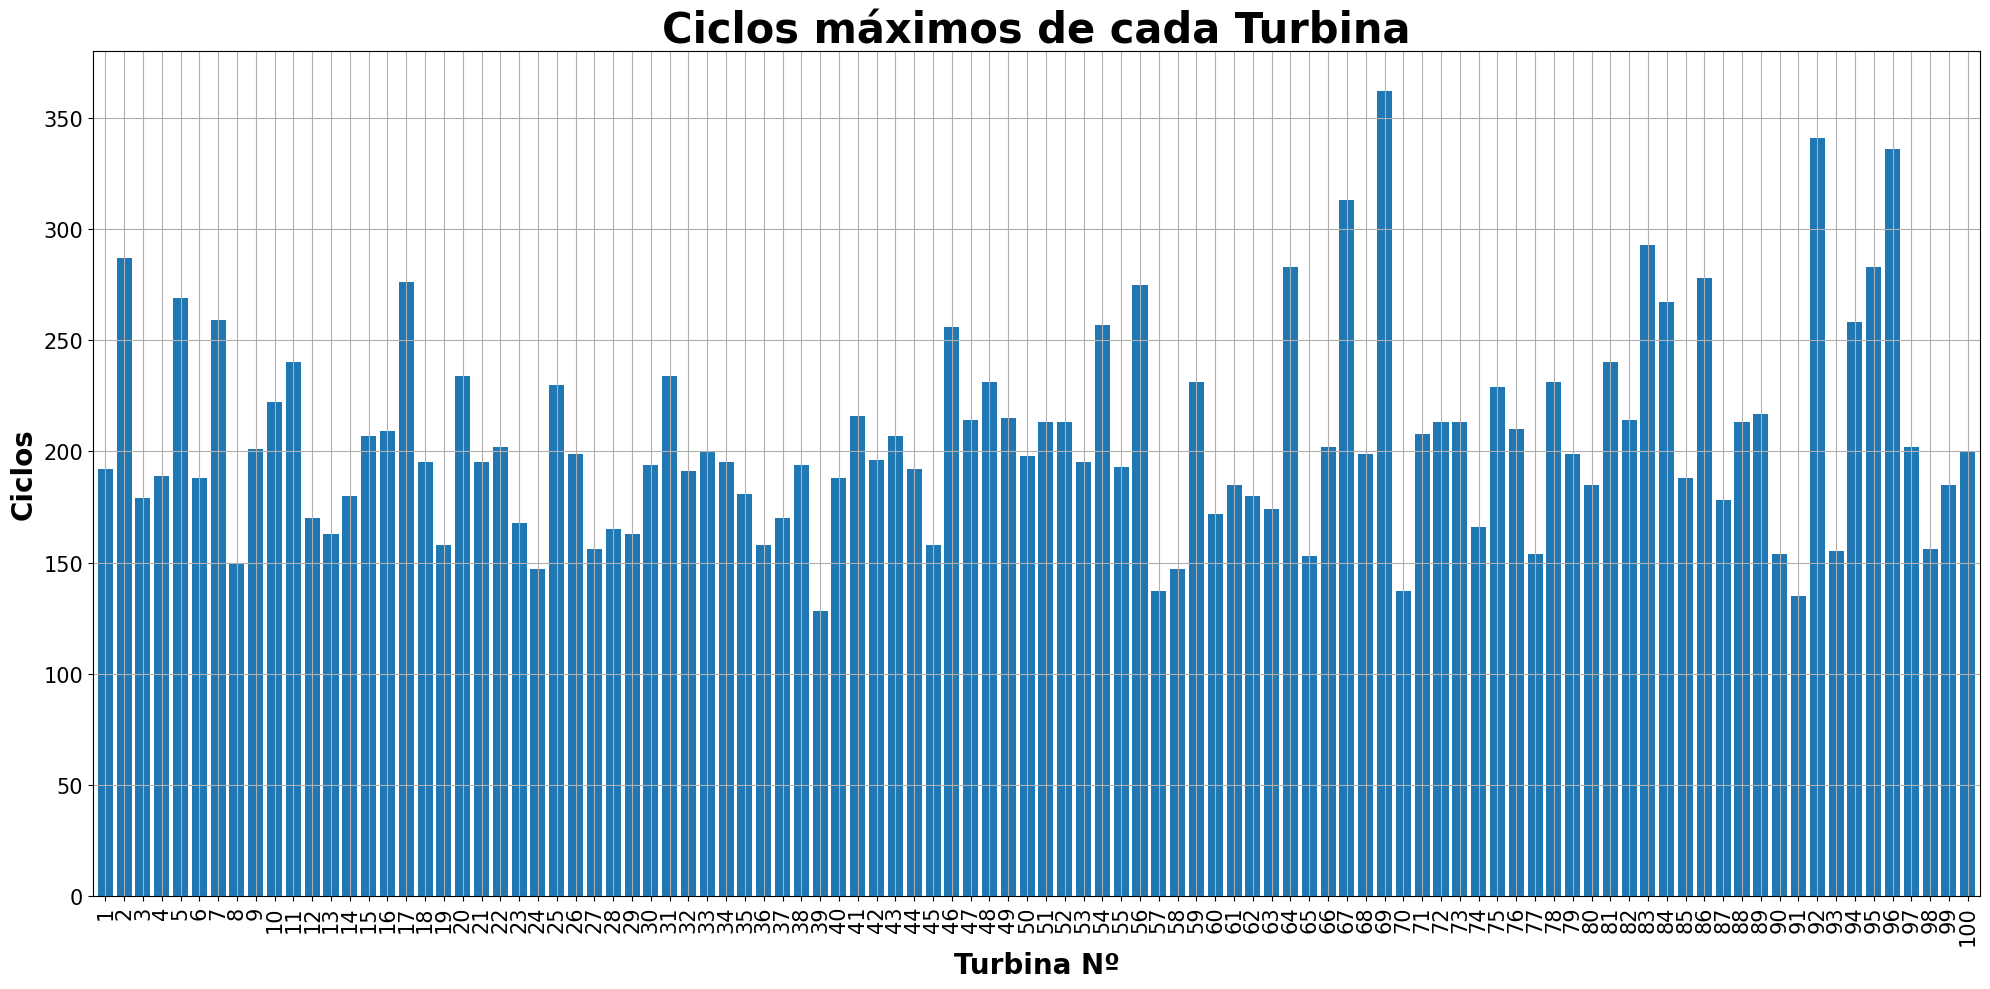

In [89]:
ciclos_maximos = train[index_names].groupby('unit_number').max()
plt.figure(figsize=(20,10))
ax = ciclos_maximos['time_cycles'].plot(kind='bar', width=0.8, stacked=True, align='center')
plt.title('Ciclos máximos de cada Turbina',fontweight='bold',size=30)
plt.xlabel('Turbina Nº',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('Ciclos',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Distribución de los ciclos

Text(0.5, 9.444444444444459, 'Ciclos máximos')

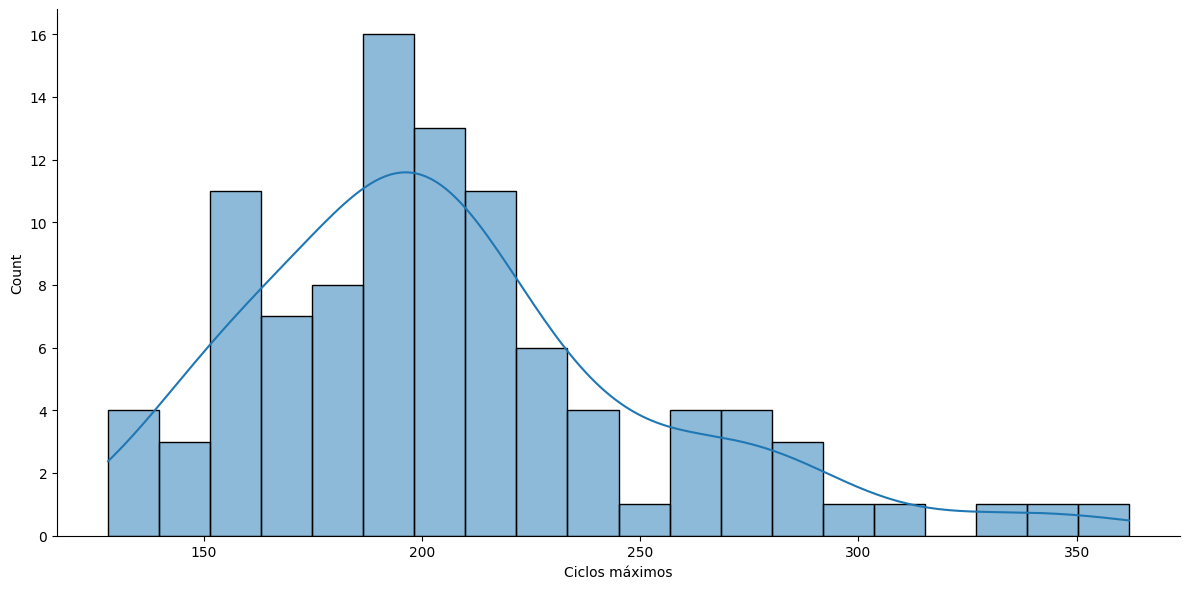

In [90]:
sns.displot(ciclos_maximos['time_cycles'], kde=True, bins=20, height=6, aspect=2)
plt.xlabel('Ciclos máximos')

---

### Añadimos la columna RUL a la data

Indica los ciclos restantes de cada unidad antes de que falle.

In [91]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number')
    max_time_cycles = train_grouped_by_unit['time_cycles'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1) 
    return merged

In [92]:
train = add_RUL_column(train)

In [93]:
train[['unit_number','RUL']]

unit_number  RUL
0                1  191
1                1  190
2                1  189
3                1  188
4                1  187
...            ...  ...
20626          100    4
20627          100    3
20628          100    2
20629          100    1
20630          100    0

[20631 rows x 2 columns]

# BORRAR

In [94]:
#Rul analysis
maxrul_u = train.groupby('unit_number').max().reset_index()
maxrul_u.head()

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0            1          192     0.0047     0.0005      100.0  518.67  644.21   
1            2          287     0.0076     0.0006      100.0  518.67  643.94   
2            3          179     0.0058     0.0005      100.0  518.67  643.93   
3            4          189     0.0059     0.0006      100.0  518.67  644.53   
4            5          269     0.0055     0.0005      100.0  518.67  644.02   

       s_3      s_4    s_5  ...     s_13     s_14    s_15  s_16  s_17  s_18  \
0  1605.44  1432.52  14.62  ...  2388.35  8140.58  8.5227  0.03   398  2388   
1  1610.10  1431.17  14.62  ...  2388.26  8175.57  8.5377  0.03   398  2388   
2  1606.50  1438.51  14.62  ...  2388.20  8255.34  8.5363  0.03   399  2388   
3  1612.11  1434.12  14.62  ...  2388.17  8259.42  8.5462  0.03   399  2388   
4  1609.41  1434.59  14.62  ...  2388.23  8215.19  8.5410  0.03   398  2388   

    s_19   s_20     s_21  RUL  
0  100.0  39.18  23.4999  191  
1  100.0  39.24  23.6005  286  
2  100.0  39.23  23.5181  178  
3  100.0  39.21  23.5074  188  
4  100.0  39.29  23.5503  268  

[5 rows x 27 columns]

---

### Correlaciones

<Axes: >

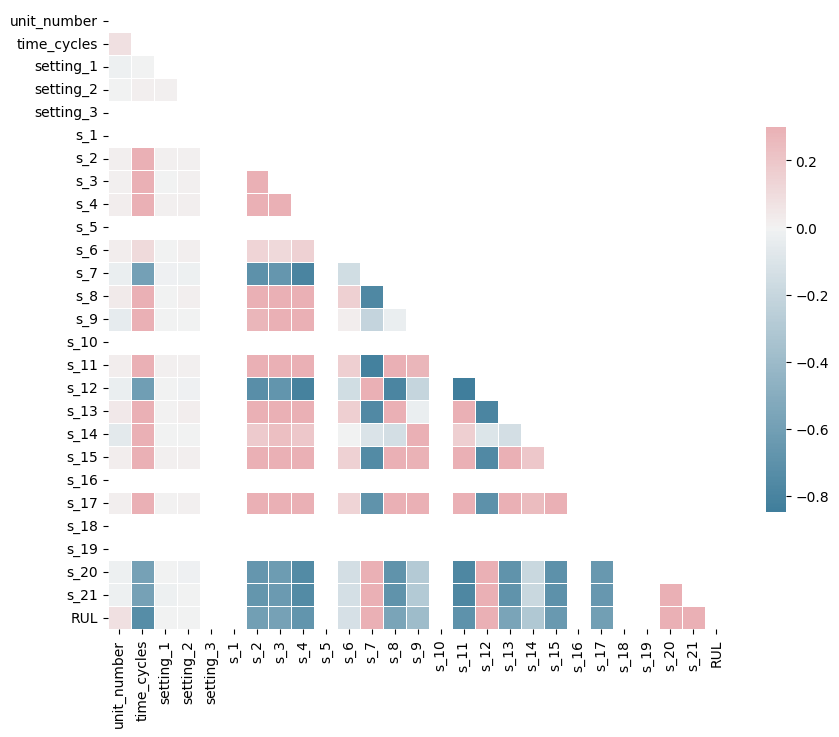

In [95]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

Vemos que algunas variables tienen una fuerte correlación con la columna a predecir "RUL" y otras que prácticamente no tienen correlación.

---

### Questions to answer : 

- Can we efficiently predict the remaining useful time for the engine (error significance) ?
- Which features are the most important for predicting the failure of the turbofan engine ?
- Does adding historical data improve our model ? 
- Is the collected data sufficient enough to give an accurate prediction ?
- How can we turn our problem to a classification one ?


First, let us match each sensor with its real signification

In [96]:
Sensor_dictionary={}

dict_list=["(Fan inlet temperature) (◦R)",
           "(LPC outlet temperature) (◦R)",
           "(HPC outlet temperature) (◦R)",
           "(LPT outlet temperature) (◦R)",
           "(Fan inlet Pressure) (psia)",
           "(bypass-duct pressure) (psia)",
           "(HPC outlet pressure) (psia)",
           "(Physical fan speed) (rpm)",
           "(Physical core speed) (rpm)",
           "(Engine pressure ratio(P50/P2)",
           "(HPC outlet Static pressure) (psia)",
           "(Ratio of fuel flow to Ps30) (pps/psia)",
           "(Corrected fan speed) (rpm)",
           "(Corrected core speed) (rpm)",
           "(Bypass Ratio) ",
           "(Burner fuel-air ratio)",
           "(Bleed Enthalpy)",
           "(Required fan speed)",
           "(Required fan conversion speed)",
           "(High-pressure turbines Cool air flow)",
           "(Low-pressure turbines Cool air flow)"
           ]

i=1
for x in dict_list:
    Sensor_dictionary['s_' + str(i)] = x
    i+=1

Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

#### Evolución de las variables con respecto a la vida útil restante (RUL)

In [97]:
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):   # ploteamos las señales de solo 10 sensores (20)
            plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())

    plt.xlim(250, 0)  # invertimos el eje x para que la vida útil termine en cero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()


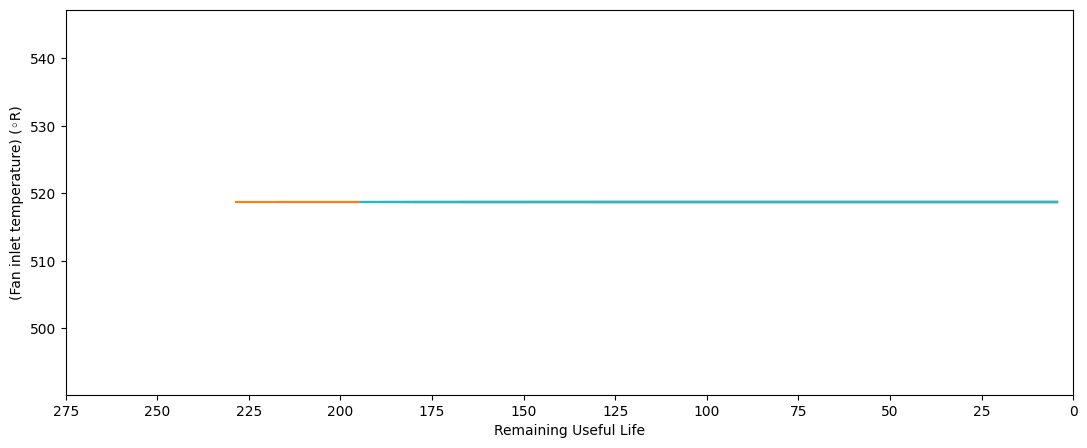

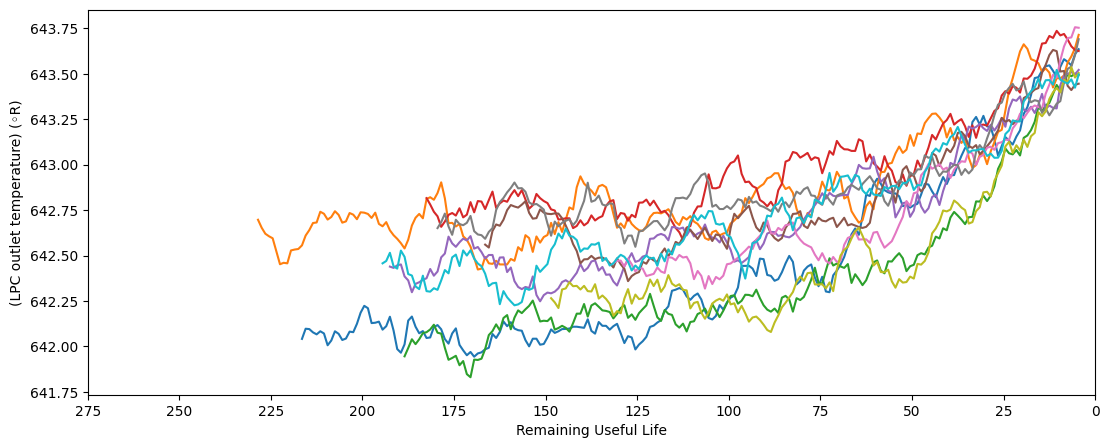

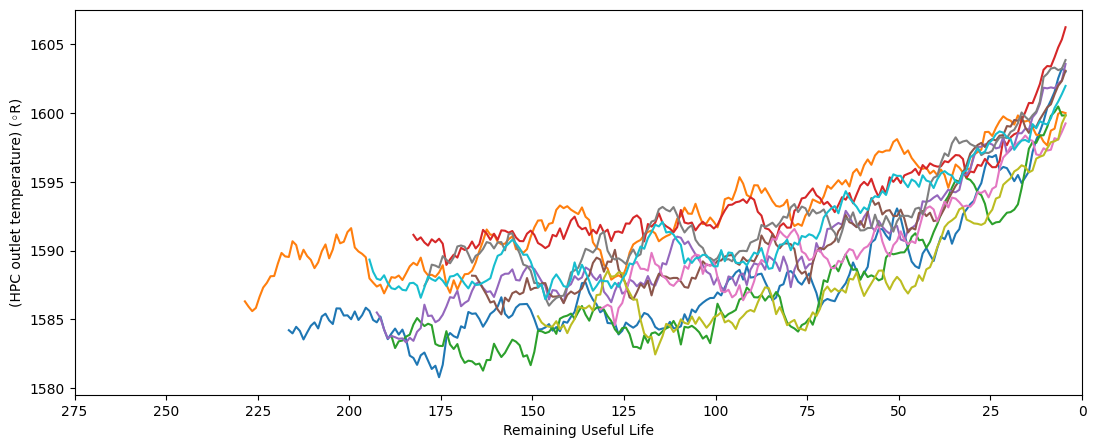

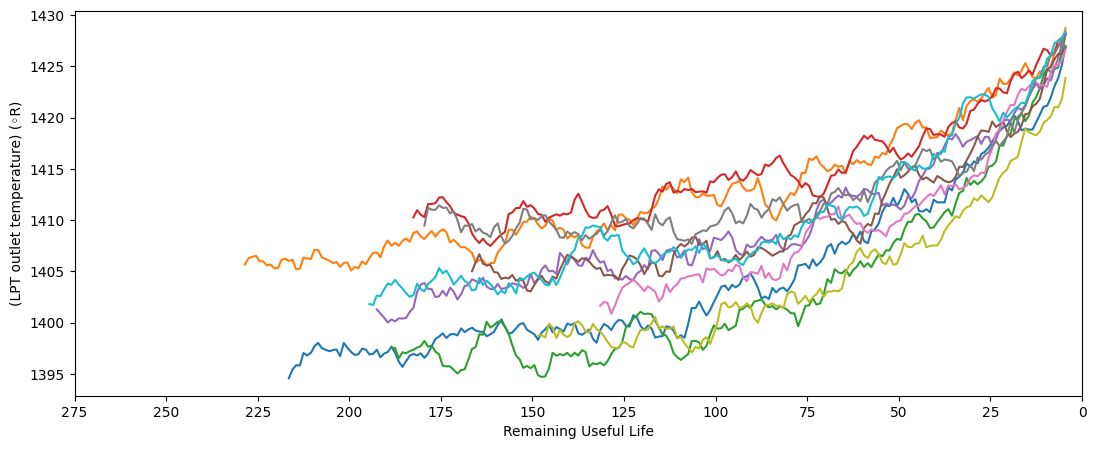

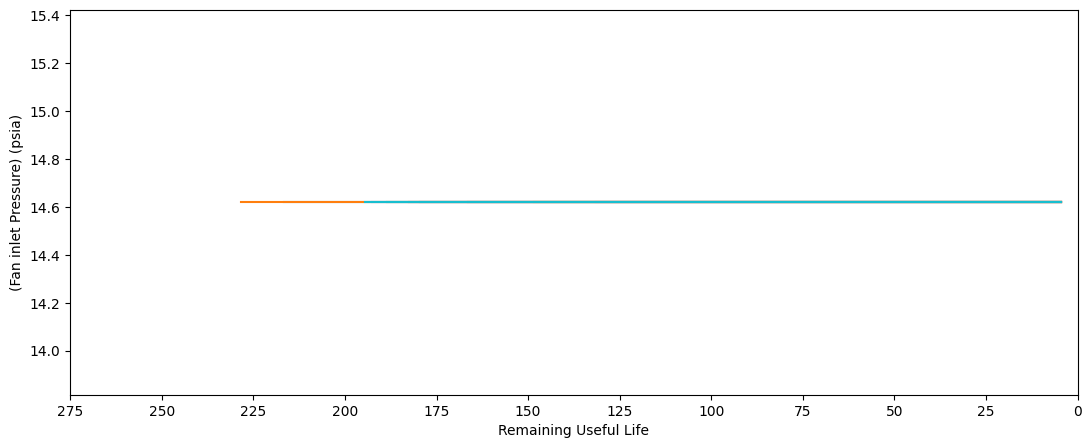

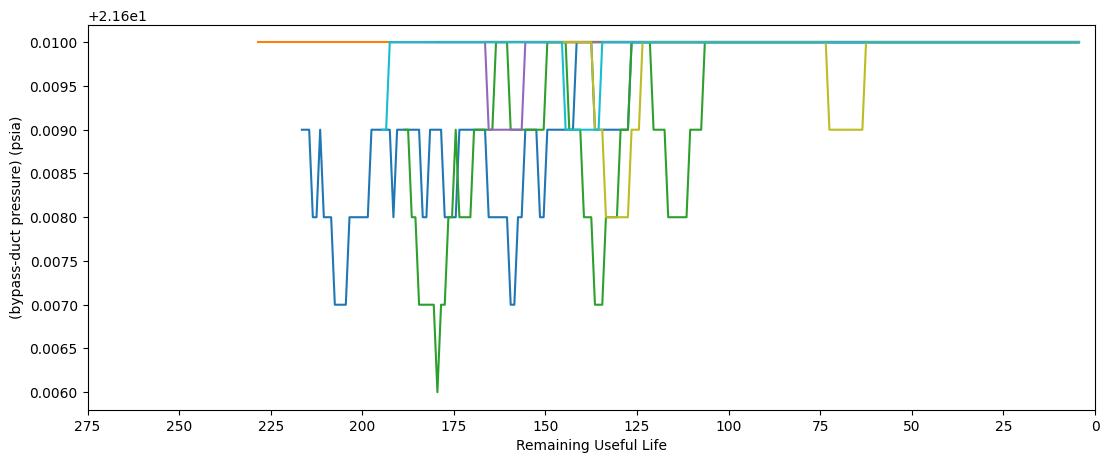

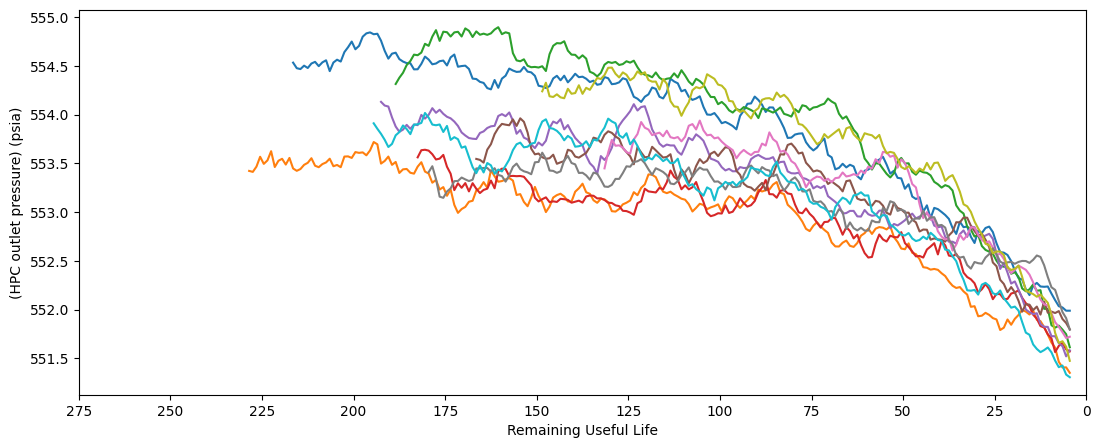

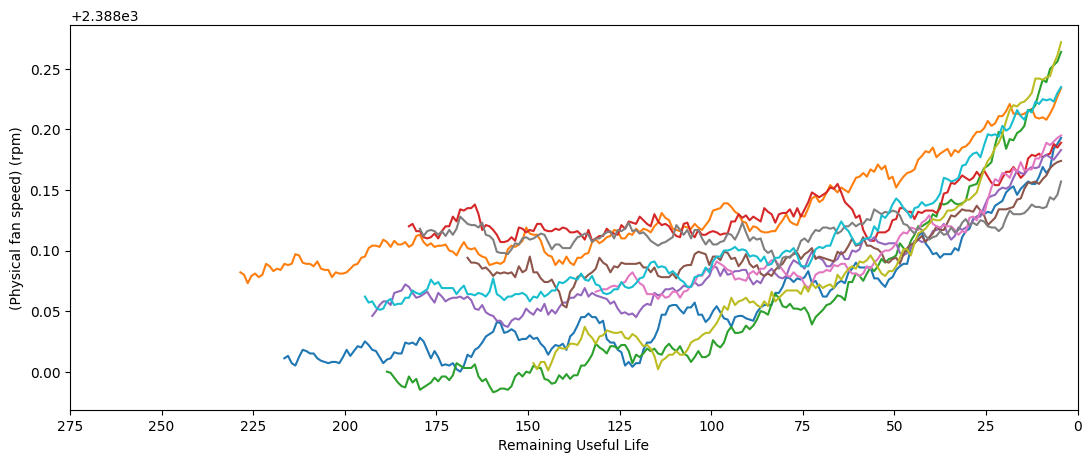

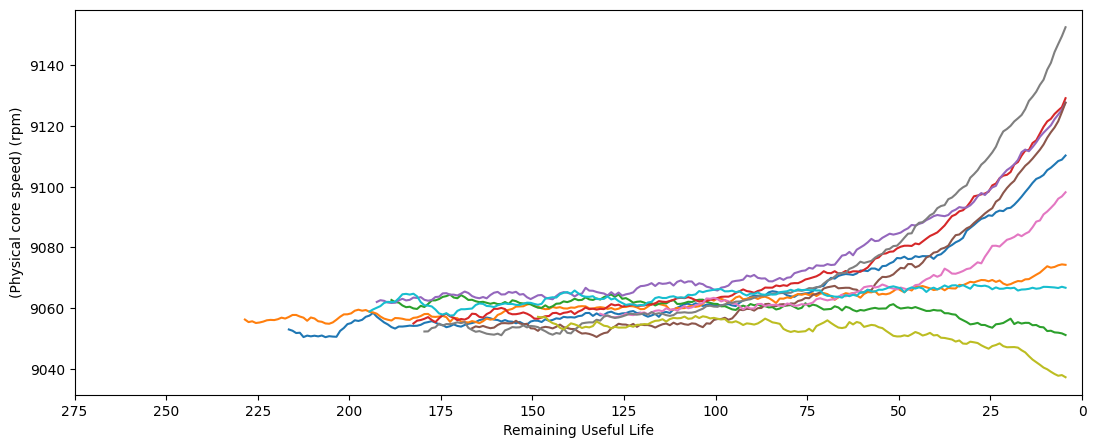

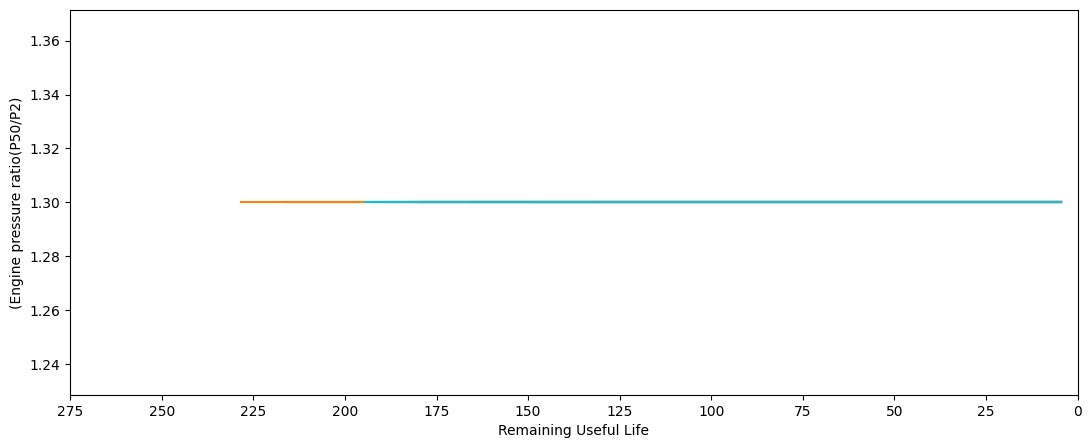

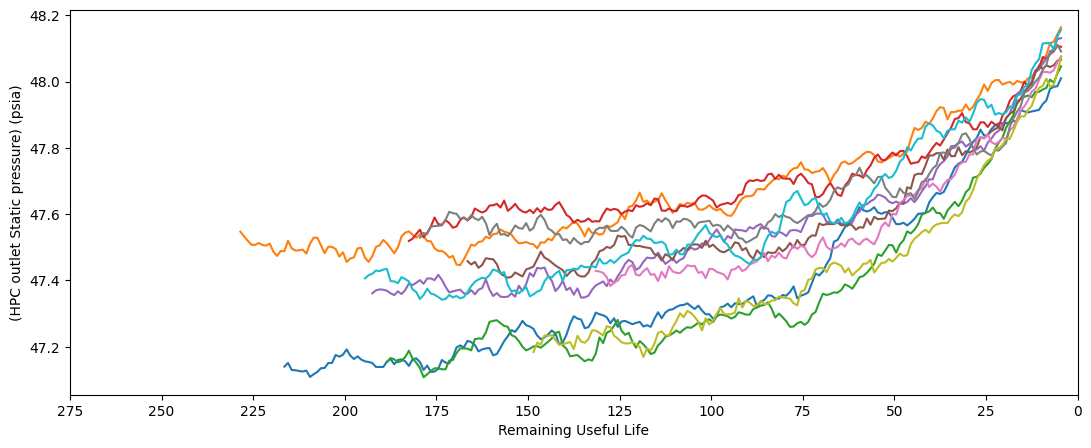

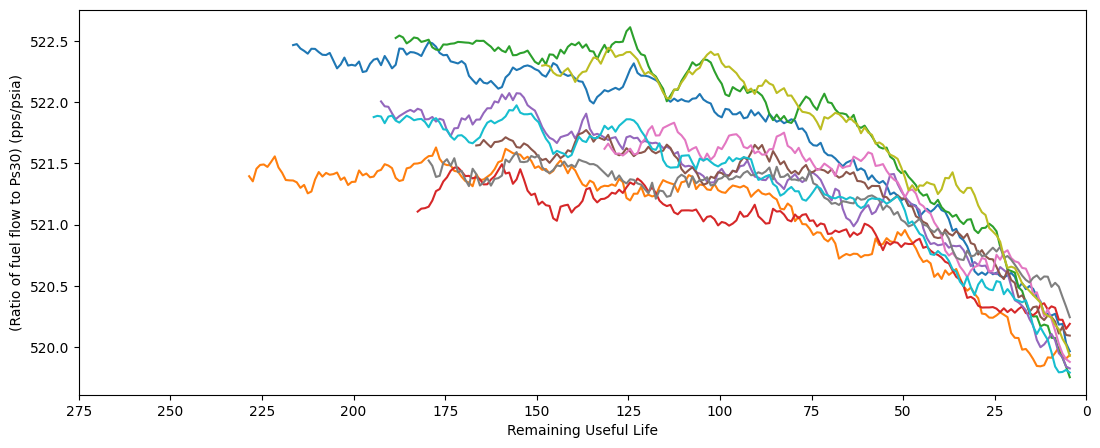

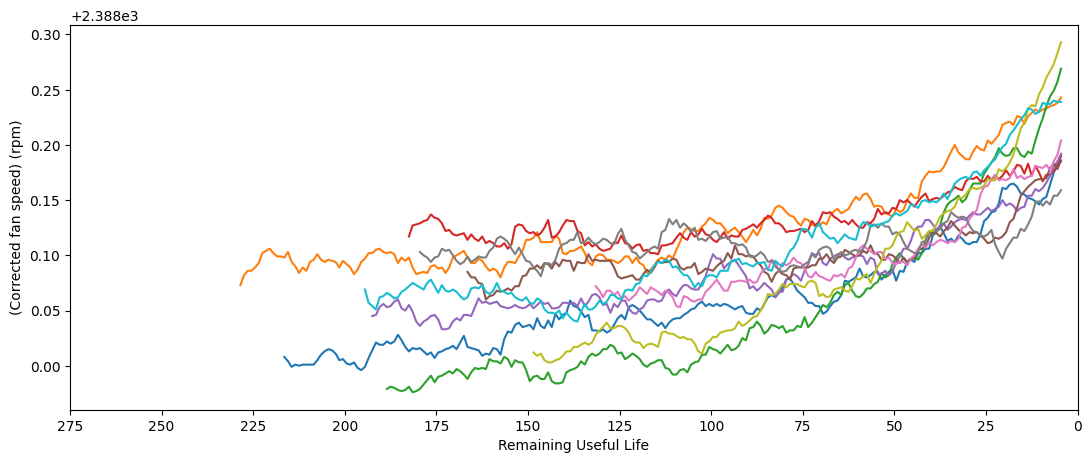

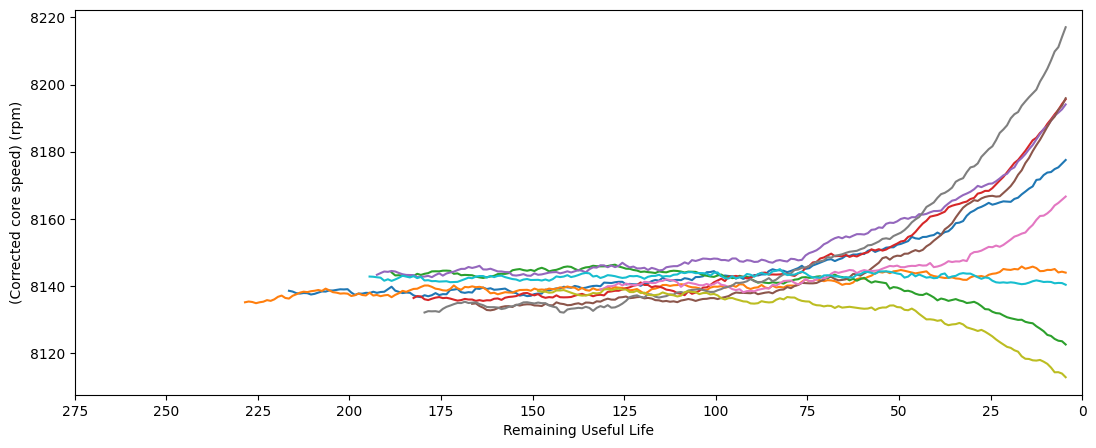

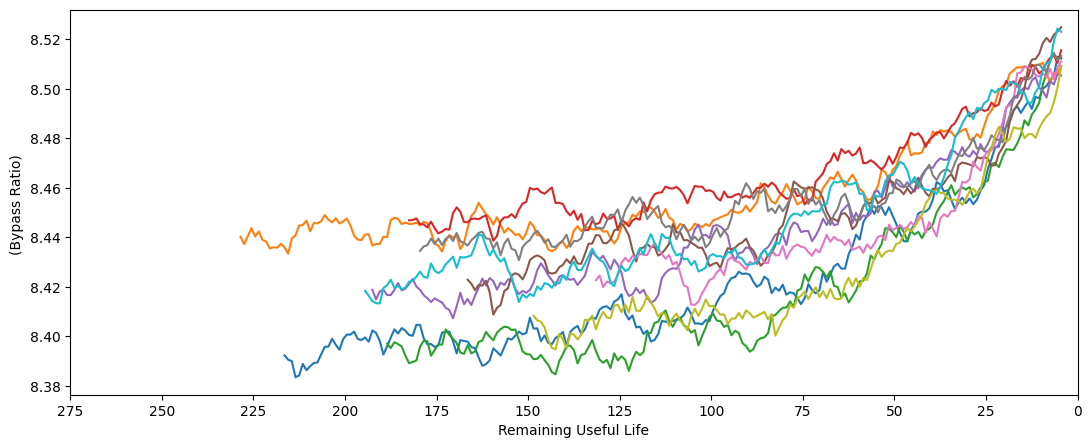

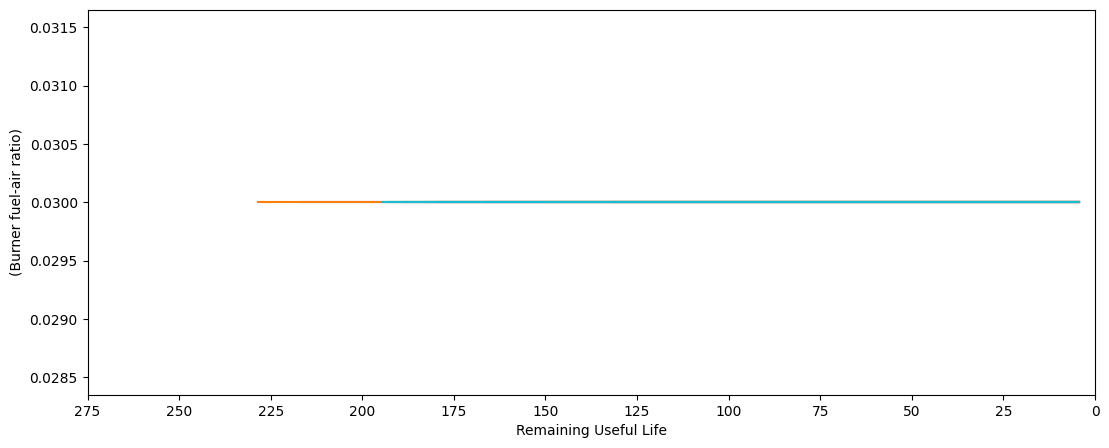

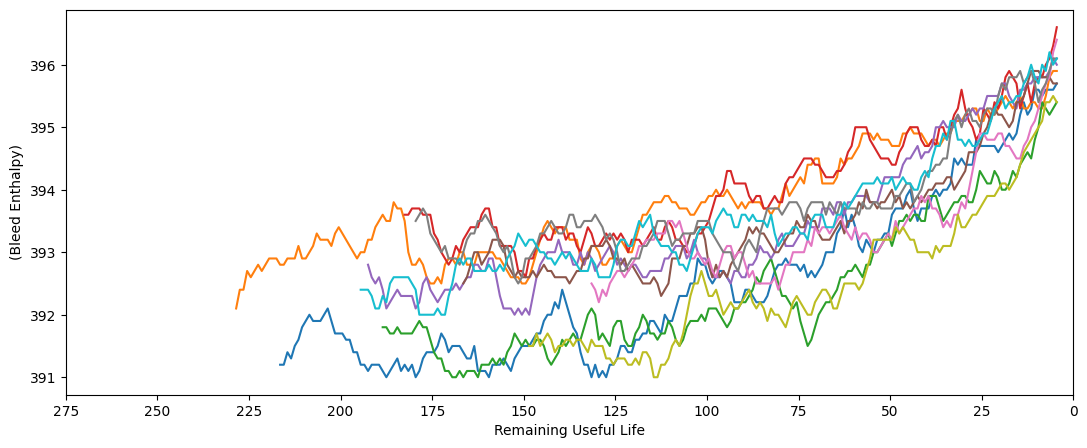

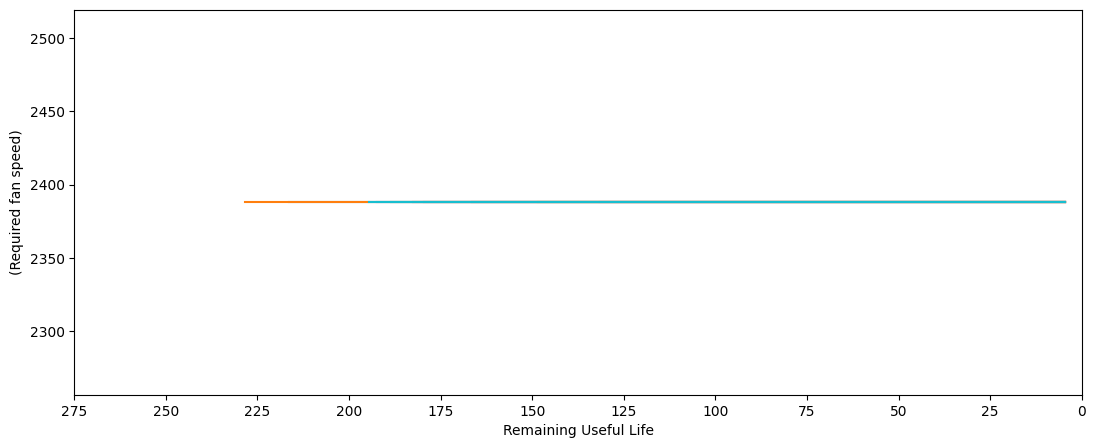

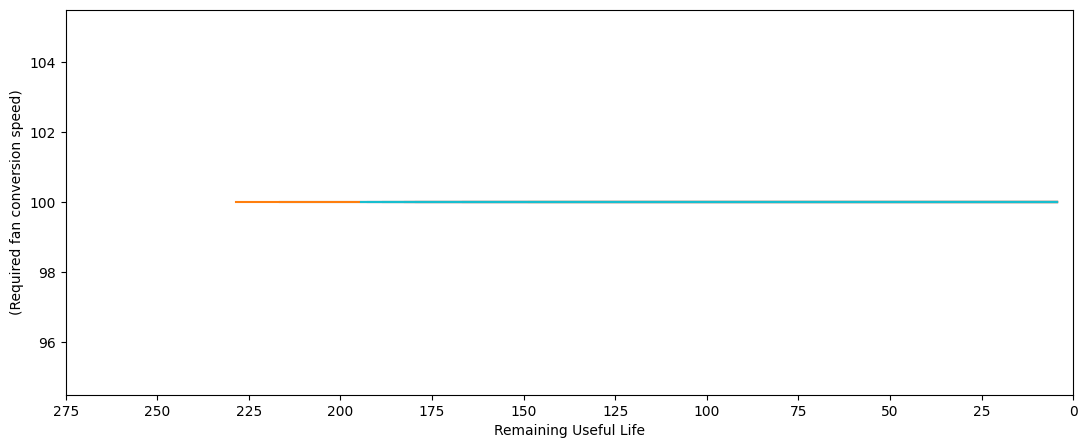

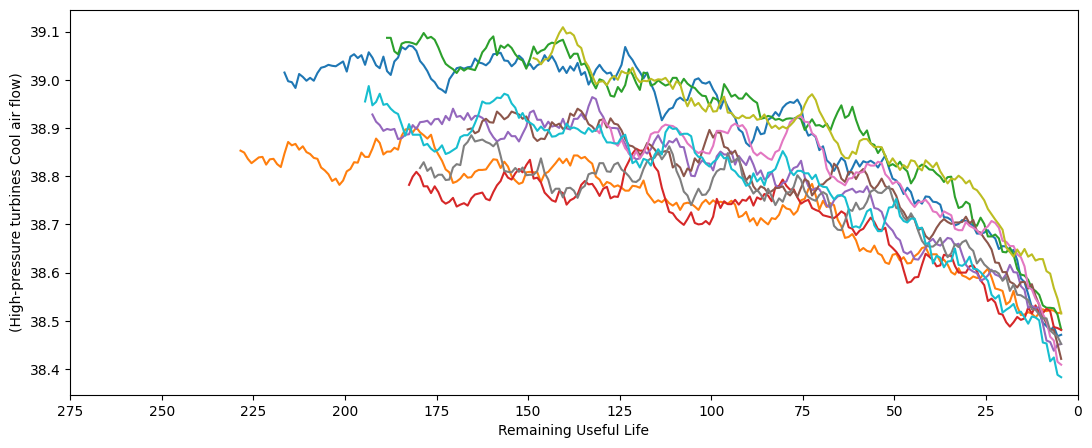

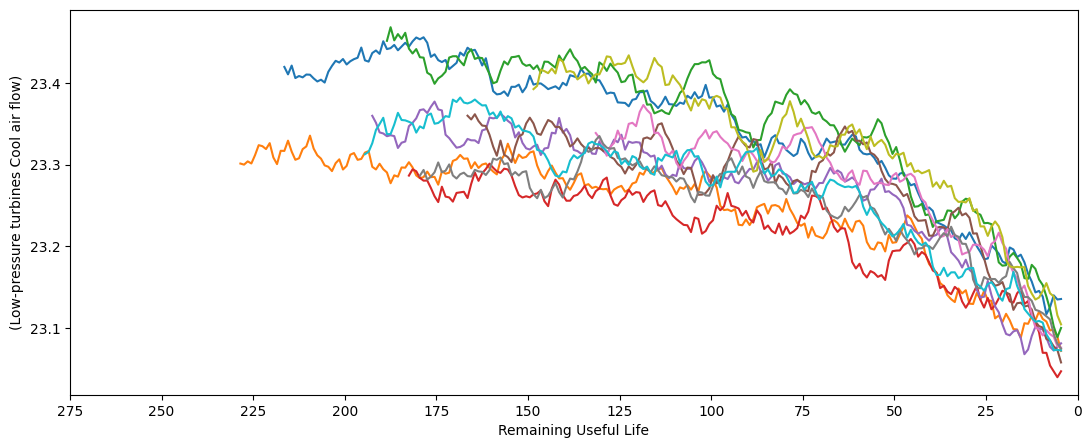

In [98]:
for i in range(1,22):
    try:
        plot_signal(train, Sensor_dictionary,'s_'+str(i))
    except:
        pass

Vemos que algunas variables (sensores) no tienen influencia en la vida de las turbinas, mas luego las vamos a descartar.

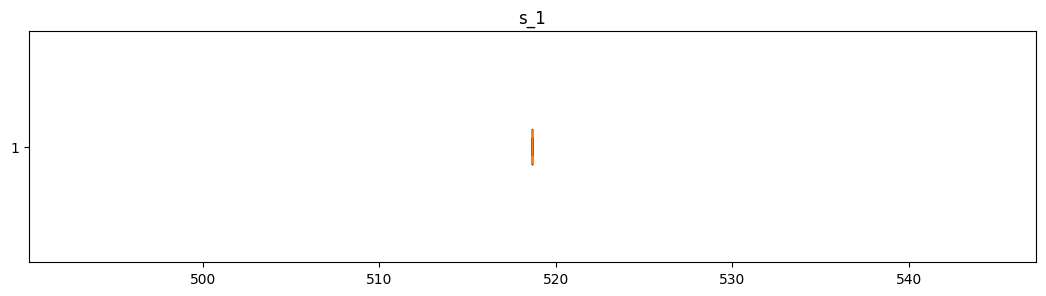

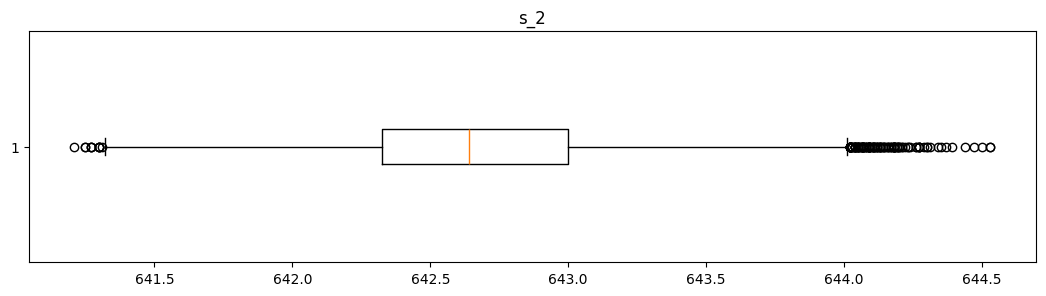

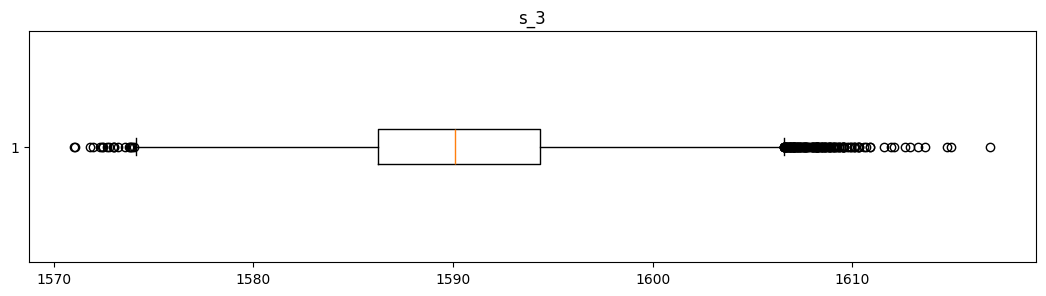

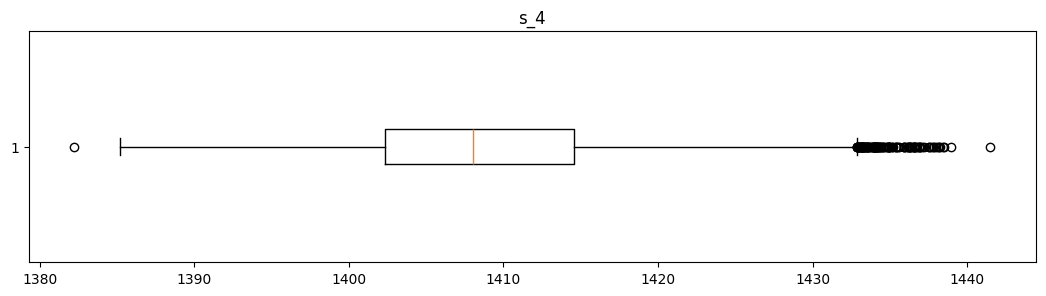

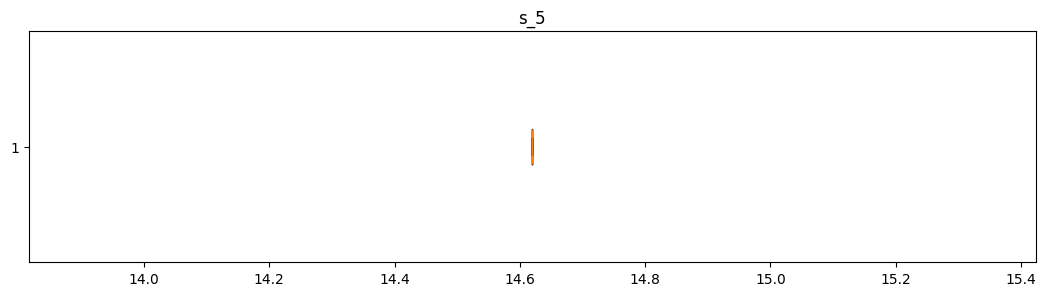

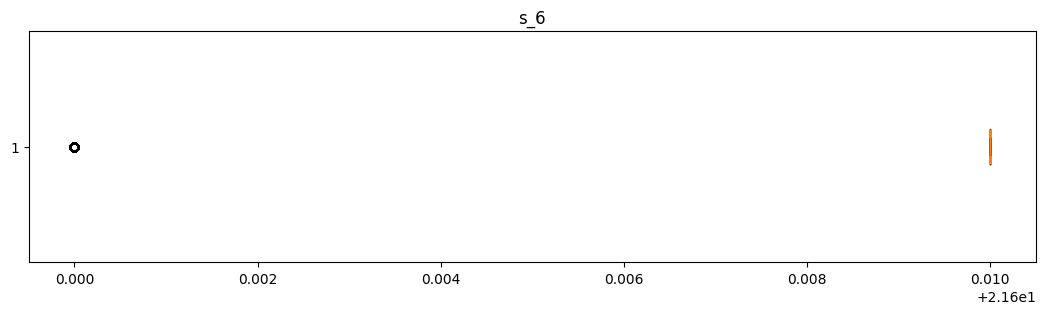

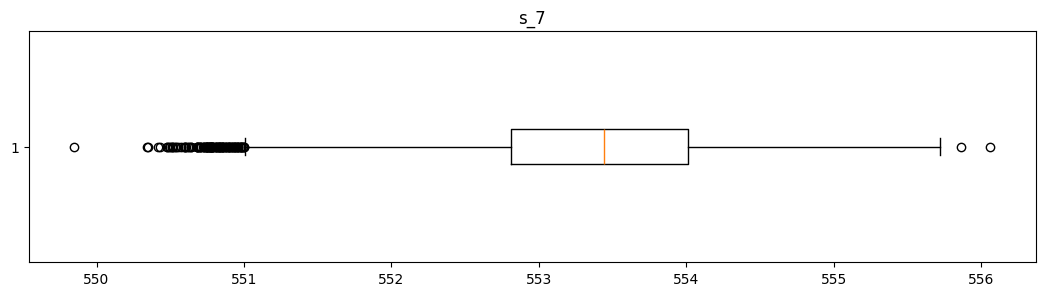

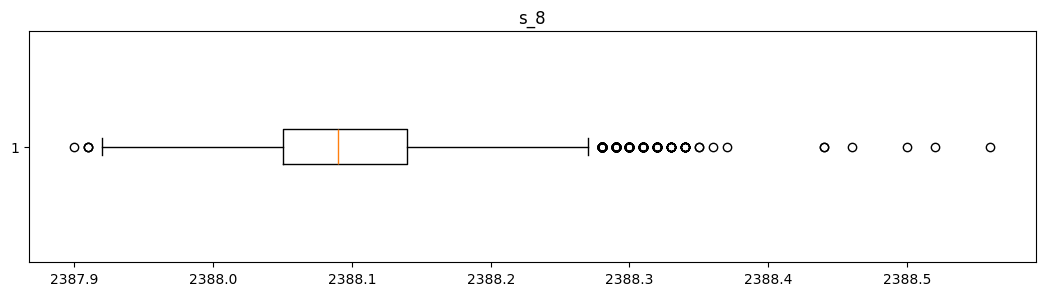

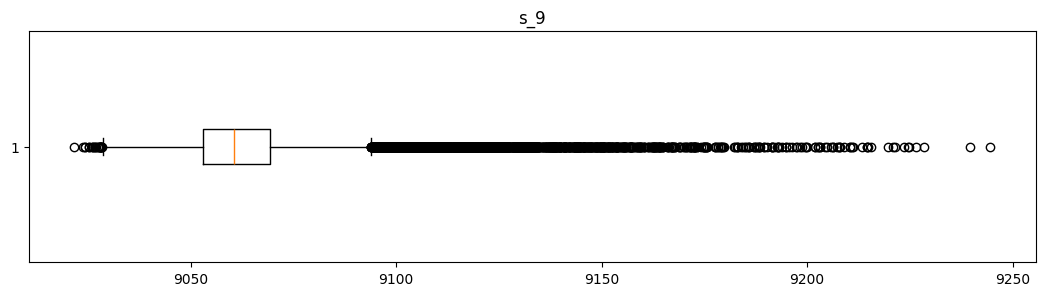

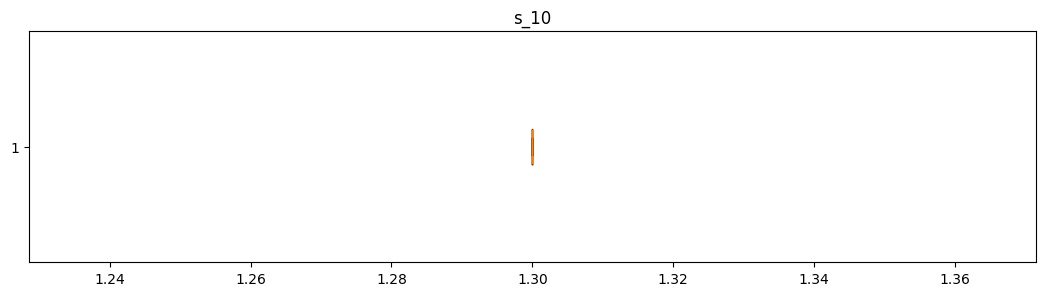

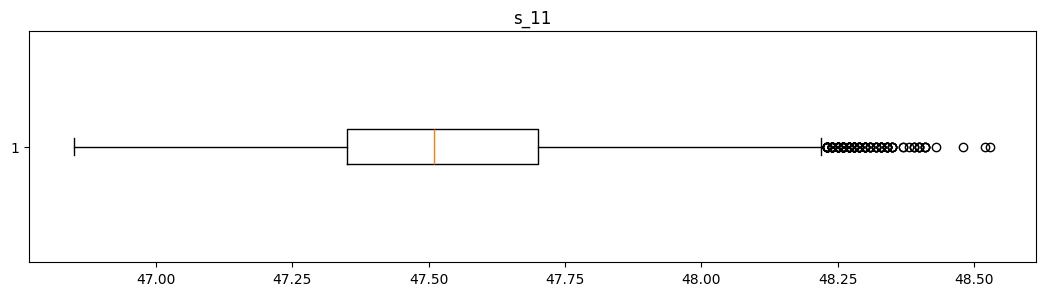

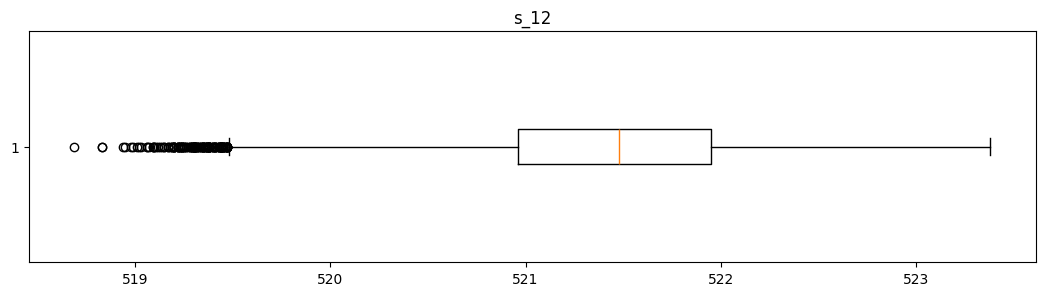

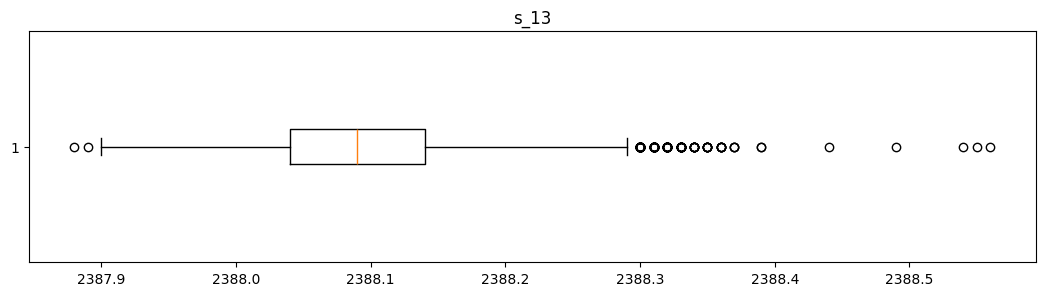

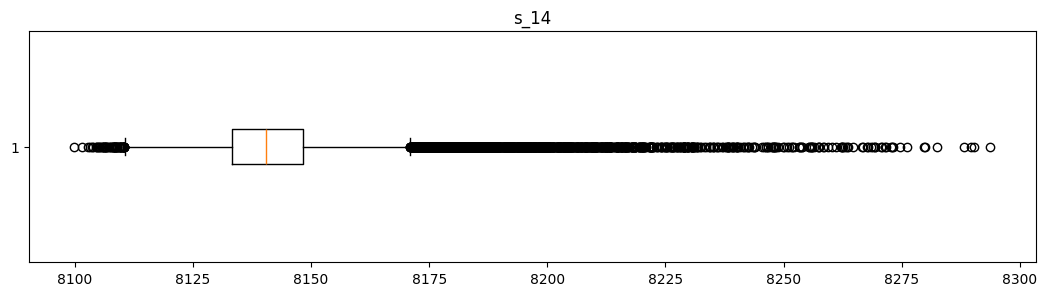

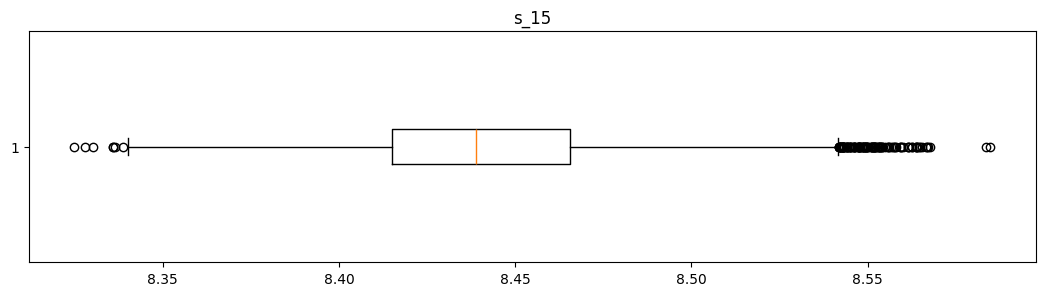

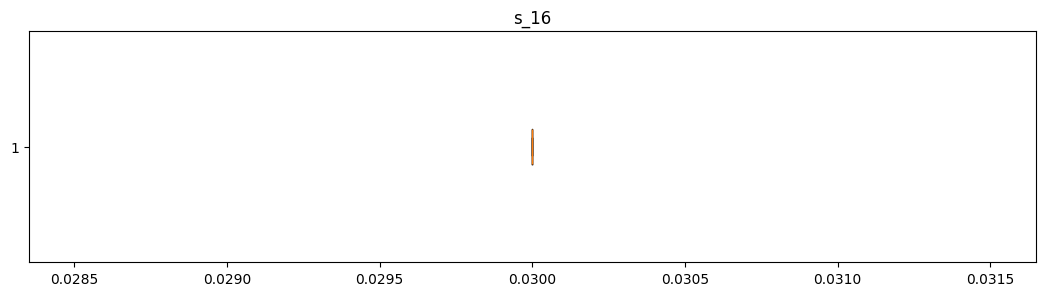

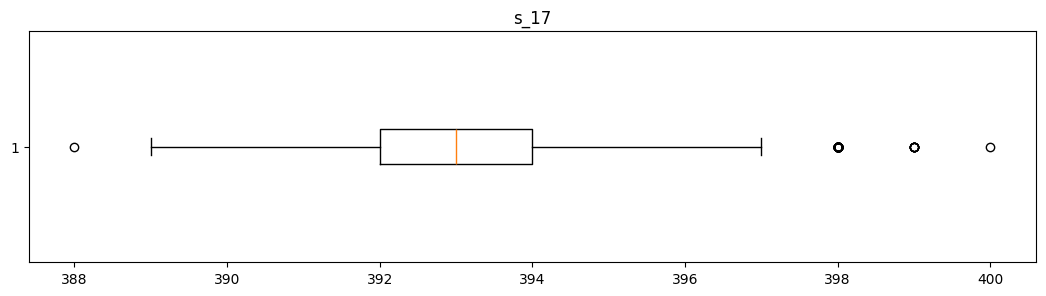

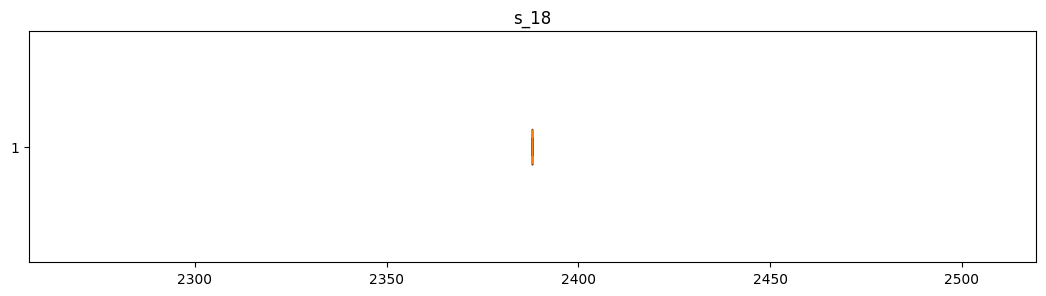

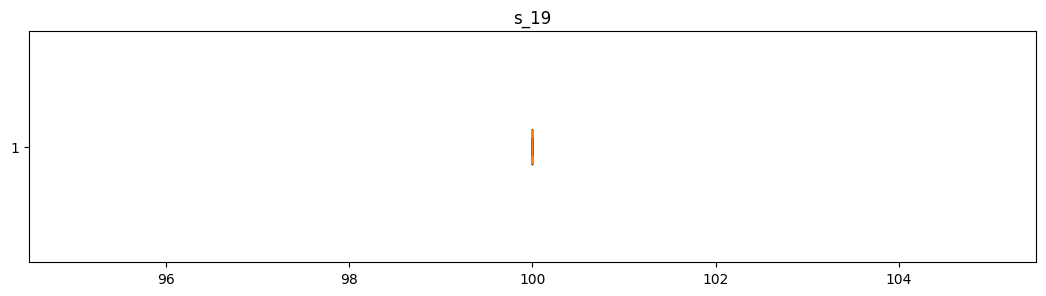

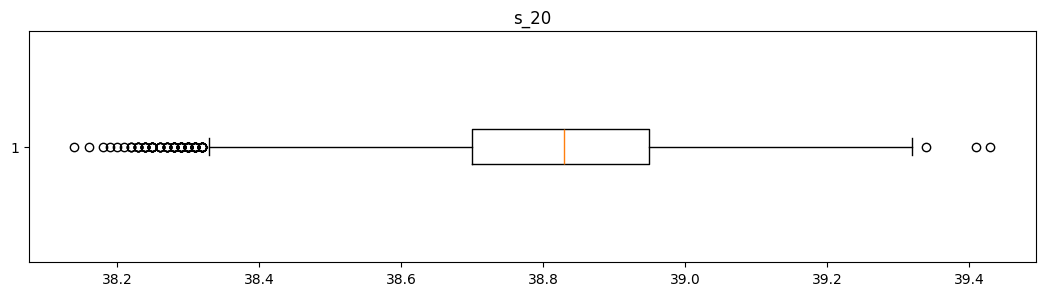

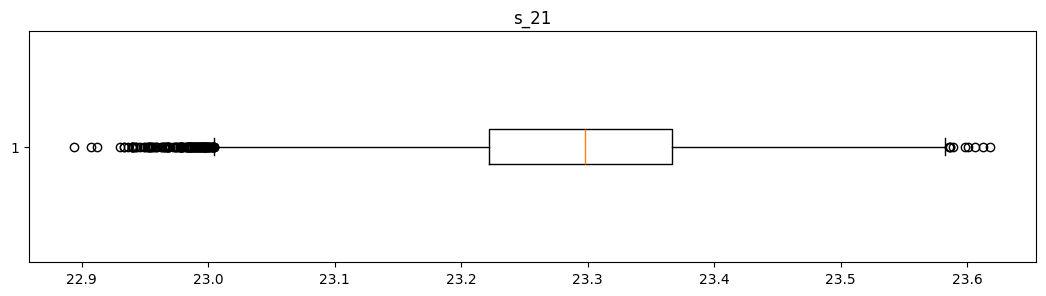

In [99]:
for x in sensor_names:
    plt.figure(figsize=(13,3))
    plt.boxplot(train[x], vert=False)
    plt.title(x)
    plt.show()

Podemos ver que los sensores 1,5,10,16,18,19 son constantes, pero el resto de los sensores tienen algunos outlayers, por lo que vamos a escalar la data.

In [100]:
train.loc[:,'s_1':].describe().transpose()

count         mean           std        min        25%        50%  \
s_1   20631.0   518.670000  0.000000e+00   518.6700   518.6700   518.6700   
s_2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s_3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s_4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s_5   20631.0    14.620000  1.776400e-15    14.6200    14.6200    14.6200   
s_6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
s_7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
s_8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
s_9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
s_10  20631.0     1.300000  0.000000e+00     1.3000     1.3000     1.3000   
s_11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
s_12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
s_13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
s_14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
s_15  20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
s_16  20631.0     0.030000  1.387812e-17     0.0300     0.0300     0.0300   
s_17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
s_18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
s_21  20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   
RUL   20631.0   107.807862  6.888099e+01     0.0000    51.0000   103.0000   

            75%        max  
s_1    518.6700   518.6700  
s_2    643.0000   644.5300  
s_3   1594.3800  1616.9100  
s_4   1414.5550  1441.4900  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    554.0100   556.0600  
s_8   2388.1400  2388.5600  
s_9   9069.4200  9244.5900  
s_10     1.3000     1.3000  
s_11    47.7000    48.5300  
s_12   521.9500   523.3800  
s_13  2388.1400  2388.5600  
s_14  8148.3100  8293.7200  
s_15     8.4656     8.5848  
s_16     0.0300     0.0300  
s_17   394.0000   400.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    38.9500    39.4300  
s_21    23.3668    23.6184  
RUL    155.0000   361.0000

También podemos observar que logicamente los sensores no manejan escalas iguales y no siguen una distribución normal, por lo que vamos a usar min-max scaler.

**Función min-max scaler:** Tranforma las variables, conteniéndolas dentro de un cierto rango.

<img src='_src/min_max_scaler.jpg' width="350" height="100">

##### Eliminamos variables innecesarias (labels y settings)

In [101]:
train.columns

Index(['unit_number', 'time_cycles', 'setting_1', 'setting_2', 'setting_3',
       's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
       's_20', 's_21', 'RUL'],
      dtype='object')

In [102]:
drop_labels = index_names + setting_names

X_train = train.drop(columns=drop_labels).copy()

X_train, X_test, y_train, y_test = train_test_split(X_train, X_train['RUL'], test_size=0.3, random_state=137)

##### Normalizamos la data

In [103]:
scaler = MinMaxScaler()

# Eliminamos la variable a predecir
X_train.drop(columns=['RUL'], inplace=True)
X_test.drop(columns=['RUL'], inplace=True)

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

# Conservamos solo el último valor de cada turbina, para coincidir con el largo de y_valid
X_valid = valid.groupby('unit_number').last().reset_index().drop(columns=drop_labels)

X_valid_s = scaler.fit_transform(X_valid)


In [104]:
print(X_valid_s.shape)
print(y_valid.shape)

(100, 21)
(100, 1)


#### Vemos la distribución de las variables

array([[<Axes: title={'center': 's_2'}>, <Axes: title={'center': 's_3'}>,
        <Axes: title={'center': 's_4'}>, <Axes: title={'center': 's_7'}>],
       [<Axes: title={'center': 's_8'}>, <Axes: title={'center': 's_9'}>,
        <Axes: title={'center': 's_11'}>,
        <Axes: title={'center': 's_12'}>],
       [<Axes: title={'center': 's_13'}>,
        <Axes: title={'center': 's_14'}>,
        <Axes: title={'center': 's_15'}>,
        <Axes: title={'center': 's_17'}>],
       [<Axes: title={'center': 's_20'}>,
        <Axes: title={'center': 's_21'}>, <Axes: >, <Axes: >]],
      dtype=object)

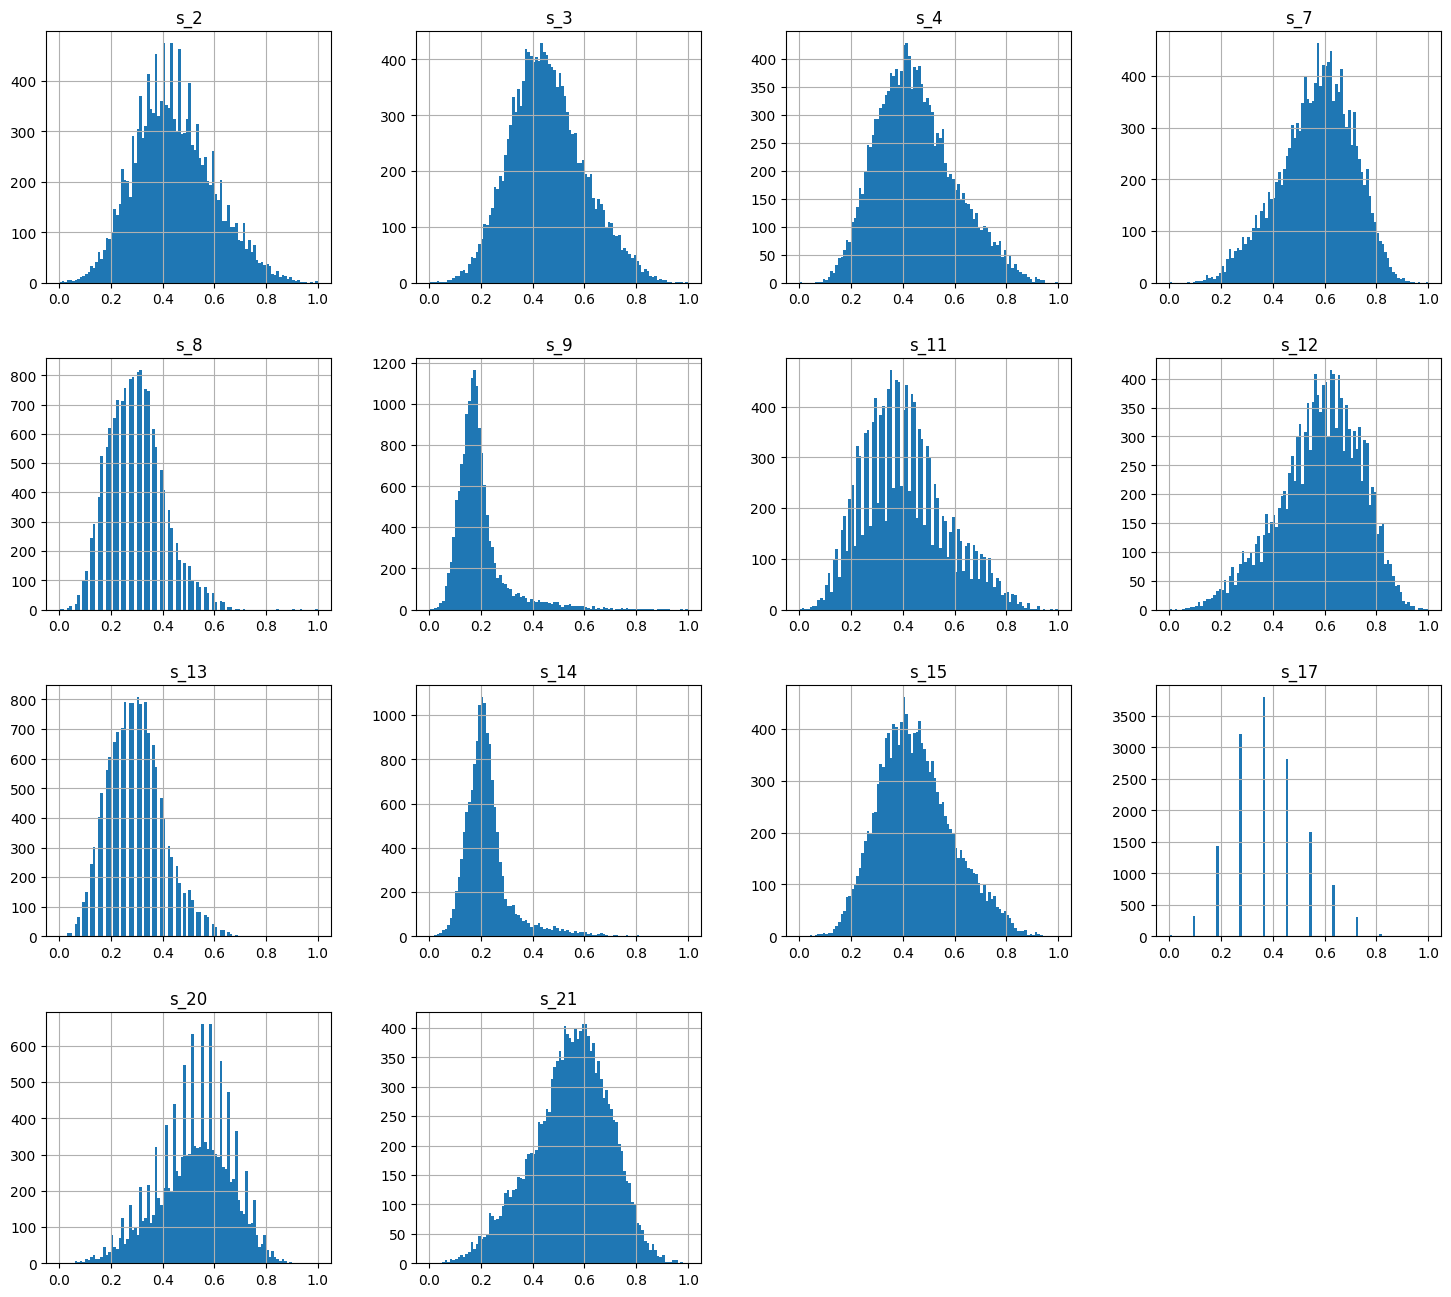

In [105]:
sensor_names=[f's_{i}' for i in range(1,22) if i not in [1,5,6,10,16,18,19]]
pd.DataFrame(X_train_s, columns=[f's_{i}' for i in range(1,22)])[sensor_names].hist(bins=100, figsize=(18,16))

## Instanciación e Implementación de modelos.

#### Regresión lineal

In [106]:
class Linear_Regression():
    def __init__(self, lr=0.01, iterations=150 ):
        self.lr = lr
        self.iterations = iterations

    def fit(self, X, Y):
        self.l, self.p = X.shape
        # weight initializer
        self.W = np.zeros(self.p)
        self.b = 0
        self.X = X
        self.Y = Y
        # gradientlearning
        for i in range(self.iterations):
            self.weight_updater()
        return self

    def weight_updater(self):
        Y_pred = self.predict(self.X)
        #  gradients  
        dW = - (2 * (self.X.T).dot(self.Y - Y_pred)) / self.l
        db = - 2 * np.sum(self.Y - Y_pred) / self.l
        # new weights assigned
        self.b = self.b - self.lr * db
        self.W = self.W - self.lr * dW
        return self

    def predict( self, X ) :
          # Y_pr=X.W+b
        return X.dot( self.W ) + self.b

### Fución para evaluar resultados

In [107]:
# R2 score y RMSE
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print(f'{label} set RMSE:{rmse}, R2:{variance}')

In [108]:
# función para graficar y comparar la data real con la predicha
def plot_predActual(y_test, y_test_hat):
  
    indices = np.arange(len(y_test_hat))
    wth= 0.6
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values]
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='b', label='True RUL')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='Predicted RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

### Primero con todas las variables y sin data histórica

#### Regresión lineal

In [109]:
lr=Linear_Regression() # Instanciación del modelo

lr.fit(X=X_train_s, Y=y_train) # Fitting

y_lr_train = lr.predict(X_train_s) # Predicción sobre train data
evaluate(y_train,y_lr_train, label='train')

y_lr_test = lr.predict(X_test_s) # Predicción sobre test data
evaluate(y_test, y_lr_test, label='test')

y_lr_valid = lr.predict(X_valid_s) # Predicción sobre data de validación
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:55.93363057735554, R2:0.3358049172522407
test set RMSE:56.16912978829695, R2:0.3458752835237675
valid set RMSE:35.608224197549475, R2:0.26575484882995914


### SVR (Support Vector Regression)

In [110]:
regressor = SVR(kernel='rbf')

regressor.fit(X_train_s, y_train) # Fitting

y_svr_train = regressor.predict(X_train_s) # Predicción sobre train data
evaluate(y_train, y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_s) # Predicción sobre test data
evaluate(y_test, y_svr_test, label='test')

y_svr_valid = lr.predict(X_valid_s) # Predicción sobre data de validación
evaluate(y_valid, y_svr_valid, label='valid')

train set RMSE:43.16985770869024, R2:0.6043502724594128
test set RMSE:45.26887208227022, R2:0.5751217340167314
valid set RMSE:35.608224197549475, R2:0.26575484882995914


#### Random Forest Regressor

In [111]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)

rf.fit(X_train_s, y_train) # Fitting

y_rf_train = rf.predict(X_train_s) # Predicción sobre train data
evaluate(y_train,y_rf_train, label='train')

y_rf_test = rf.predict(X_test_s) # Predicción sobre test data
evaluate(y_test, y_rf_test, label='test')

y_rf_valid = rf.predict(X_valid_s) # Predicción sobre data de validación
evaluate(y_valid, y_rf_valid, label='valid')

train set RMSE:15.285448481982453, R2:0.9503972210745346
test set RMSE:42.874440220256204, R2:0.6188796890852047
valid set RMSE:31.177121980708872, R2:0.4371242999471412


Graficamos con respecto a la prediccón de Random Forest, que nos dio mejor resultado

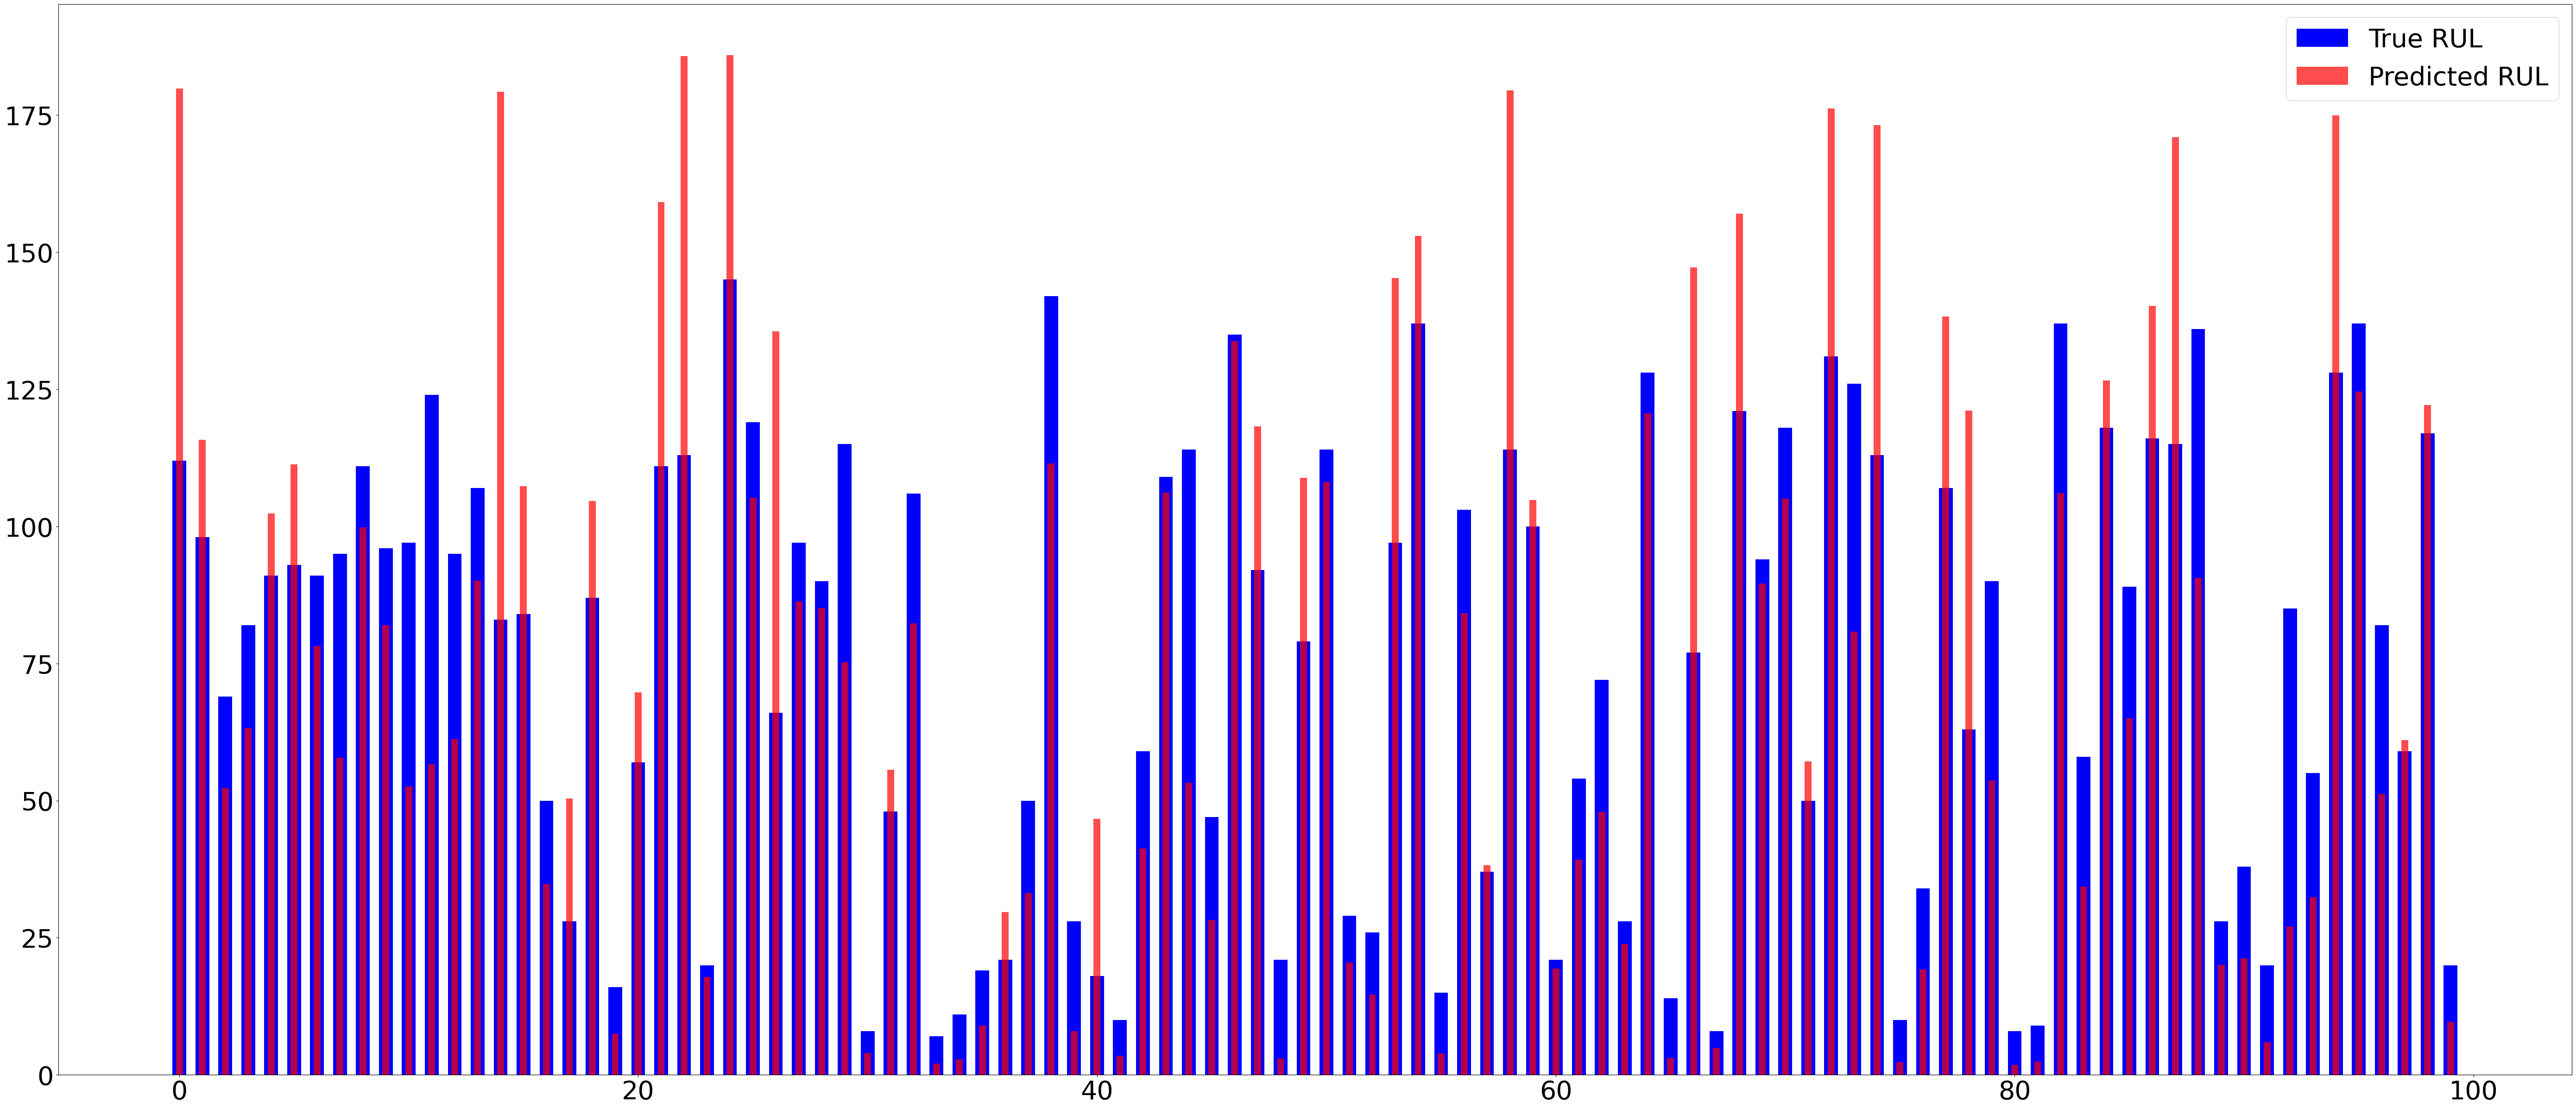

In [112]:
plot_predActual(y_valid, y_rf_valid)

### Ahora probamos sin sensores inútiles ni data histórica.

Vamos a eliminar variables de sensores que son constantes.
In  this section we drop constant signals, and we noticed in the max_time_cycles plot that in most of the time the maximum value is in the interval [190,210], hence we will set the maximum RUL to 195 through RUL clipping,

Considering that every RUL higher than 195 is equivalent to 195 will help in the prediction process as it reduces some overhead without affecting the main objective as 195 is already a high RUL.

In [113]:
print(f'RUL máximo de train: {y_train.max()}')
print(f'RUL promedio de train: {y_train.mean()}\n')
print(f'RUL máximo de test: {y_test.max()}')
print(f'RUL promedio de test: {y_test.mean()}\n')
print(f'RUL máximo de validación: {y_valid.max()}')
print(f'RUL promedio de validación: {y_valid.mean()}')

RUL máximo de train: 360
RUL promedio de train: 107.53410428640676

RUL máximo de test: 361
RUL promedio de test: 108.4465266558966

RUL máximo de validación: RUL    145
dtype: int64
RUL promedio de validación: RUL    75.52
dtype: float64


Vemos que en la data de validación tenemos un RUL promedio mucho menor que en la de entrenamiento, lo que no favorece para nada al modelo, no es lo ideal, pero en este caso en particular vamos a limitar las variables a un RUL máximo de 160

(array([1123., 1047., 1077., 1089.,  888.,  543.,  227.,  133.,   41.,
          22.]),
 array([  0. ,  36.1,  72.2, 108.3, 144.4, 180.5, 216.6, 252.7, 288.8,
        324.9, 361. ]),
 <BarContainer object of 10 artists>)

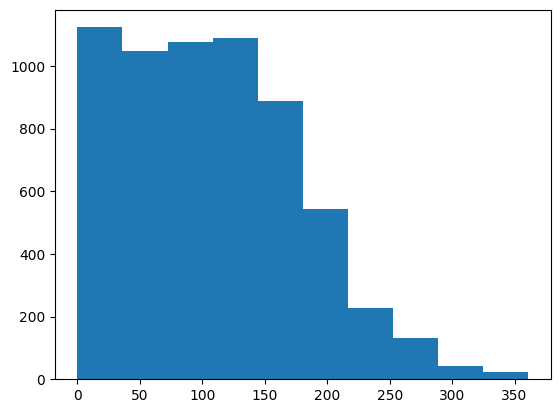

In [114]:
plt.hist(y_test)

In [115]:
y_train.shape

(14441,)

In [116]:
y_train

9154     110
12484    279
20448    182
10930     49
13513    117
        ... 
12417     63
4430     134
1171     132
18726    129
10974      5
Name: RUL, Length: 14441, dtype: int64

In [117]:
drop_labels2 = ['s_1', 's_5','s_6','s_10',  's_16', 's_18', 's_19']
X_train_2 = X_train.drop(columns=drop_labels2, axis=1) # drop the constant columns from the train dataset
X_test_2 = X_test.drop(columns=drop_labels2, axis=1)  # drop the constant columns from the test dataset

In [118]:
print(len(X_train_2))
print(len(y_train))
print(len(X_test_2))
print(len(y_test))

14441
14441
6190
6190


In [119]:
train_mask = y_train < 160
test_mask =  y_test < 160

y_train_clip = y_train[train_mask]
y_test_clip = y_test[test_mask]

X_train_2 = X_train_2[train_mask]
X_test_2 = X_test_2[test_mask]

In [120]:
print(len(X_train_2))
print(len(y_train_clip))
print(len(X_test_2))
print(len(y_test_clip))

11111
11111
4712
4712


In [121]:
X_train_2_s = scaler.fit_transform(X_train_2) # Normalizamos train
X_test_2_s = scaler.fit_transform(X_test_2) # Normalizamos test

X_valid_2 = X_valid.drop(columns=drop_labels2, axis=1)  # Eliminamos columnas de la data de validación
X_valid_2_s = scaler.fit_transform(X_valid_2) # Normalizamos data de validación

### Regresión Lineal

In [122]:
lr = Linear_Regression()
lr.fit(X=X_train_2_s, Y=y_train_clip)

y_lr_train = lr.predict(X_train_2_s)
evaluate(y_train_clip, y_lr_train, label='train')

y_lr_test = lr.predict(X_test_2_s)
evaluate(y_test_clip, y_lr_test, label='test')

y_lr_valid = lr.predict(X_valid_2_s)
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:35.75279779766439, R2:0.393165540562589
test set RMSE:34.93616473151189, R2:0.4146228026874418
valid set RMSE:28.926240893659617, R2:0.5154657814127794


### SVR

In [124]:
regressor.fit(X_train_2_s, y_train_clip)

y_svr_train = regressor.predict(X_train_2_s)
evaluate(y_train_clip, y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_2_s)
evaluate(y_test_clip, y_svr_test, label='test')

y_svr_valid = regressor.predict(X_valid_2_s)
evaluate(y_valid, y_svr_valid, label='valid')


train set RMSE:23.574591172178316, R2:0.7361612935760122
test set RMSE:25.716060391293396, R2:0.682828452216472
valid set RMSE:28.778396559140674, R2:0.5204061102730861


### Random forest

In [125]:
rf.fit(X_train_2_s, y_train_clip)
# predict and evaluate
y_rf_train = rf.predict(X_train_2_s)
evaluate(y_train_clip, y_rf_train, label='train')

y_rf_test = rf.predict(X_test_2_s)
evaluate(y_test_clip, y_rf_test, label='test')

y_rf_valid = rf.predict(X_valid_2_s)
evaluate(y_valid, y_rf_valid, label='valid')

train set RMSE:8.72746725985539, R2:0.9638401495557068
test set RMSE:24.531548299041734, R2:0.7113741224553713
valid set RMSE:27.54076317025365, R2:0.5607695937203364


In [126]:
xgb = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.02, gamma=0, subsample=0.8,colsample_bytree=0.5, max_depth=3)
xgb.fit(X_train_2_s, y_train_clip)


y_xgb_train = xgb.predict(X_train_2_s)
evaluate(y_train_clip, y_xgb_train, label='train')

y_xgb_test = xgb.predict(X_test_2_s)
evaluate(y_test_clip, y_xgb_test, label='test')

y_xgb_valid = xgb.predict(X_valid_2_s)
evaluate(y_valid, y_xgb_valid, label='valid')

train set RMSE:24.453515108001895, R2:0.71612133018435
test set RMSE:25.302772586130473, R2:0.6929411832966851
valid set RMSE:24.353127277300732, R2:0.6565607454179463


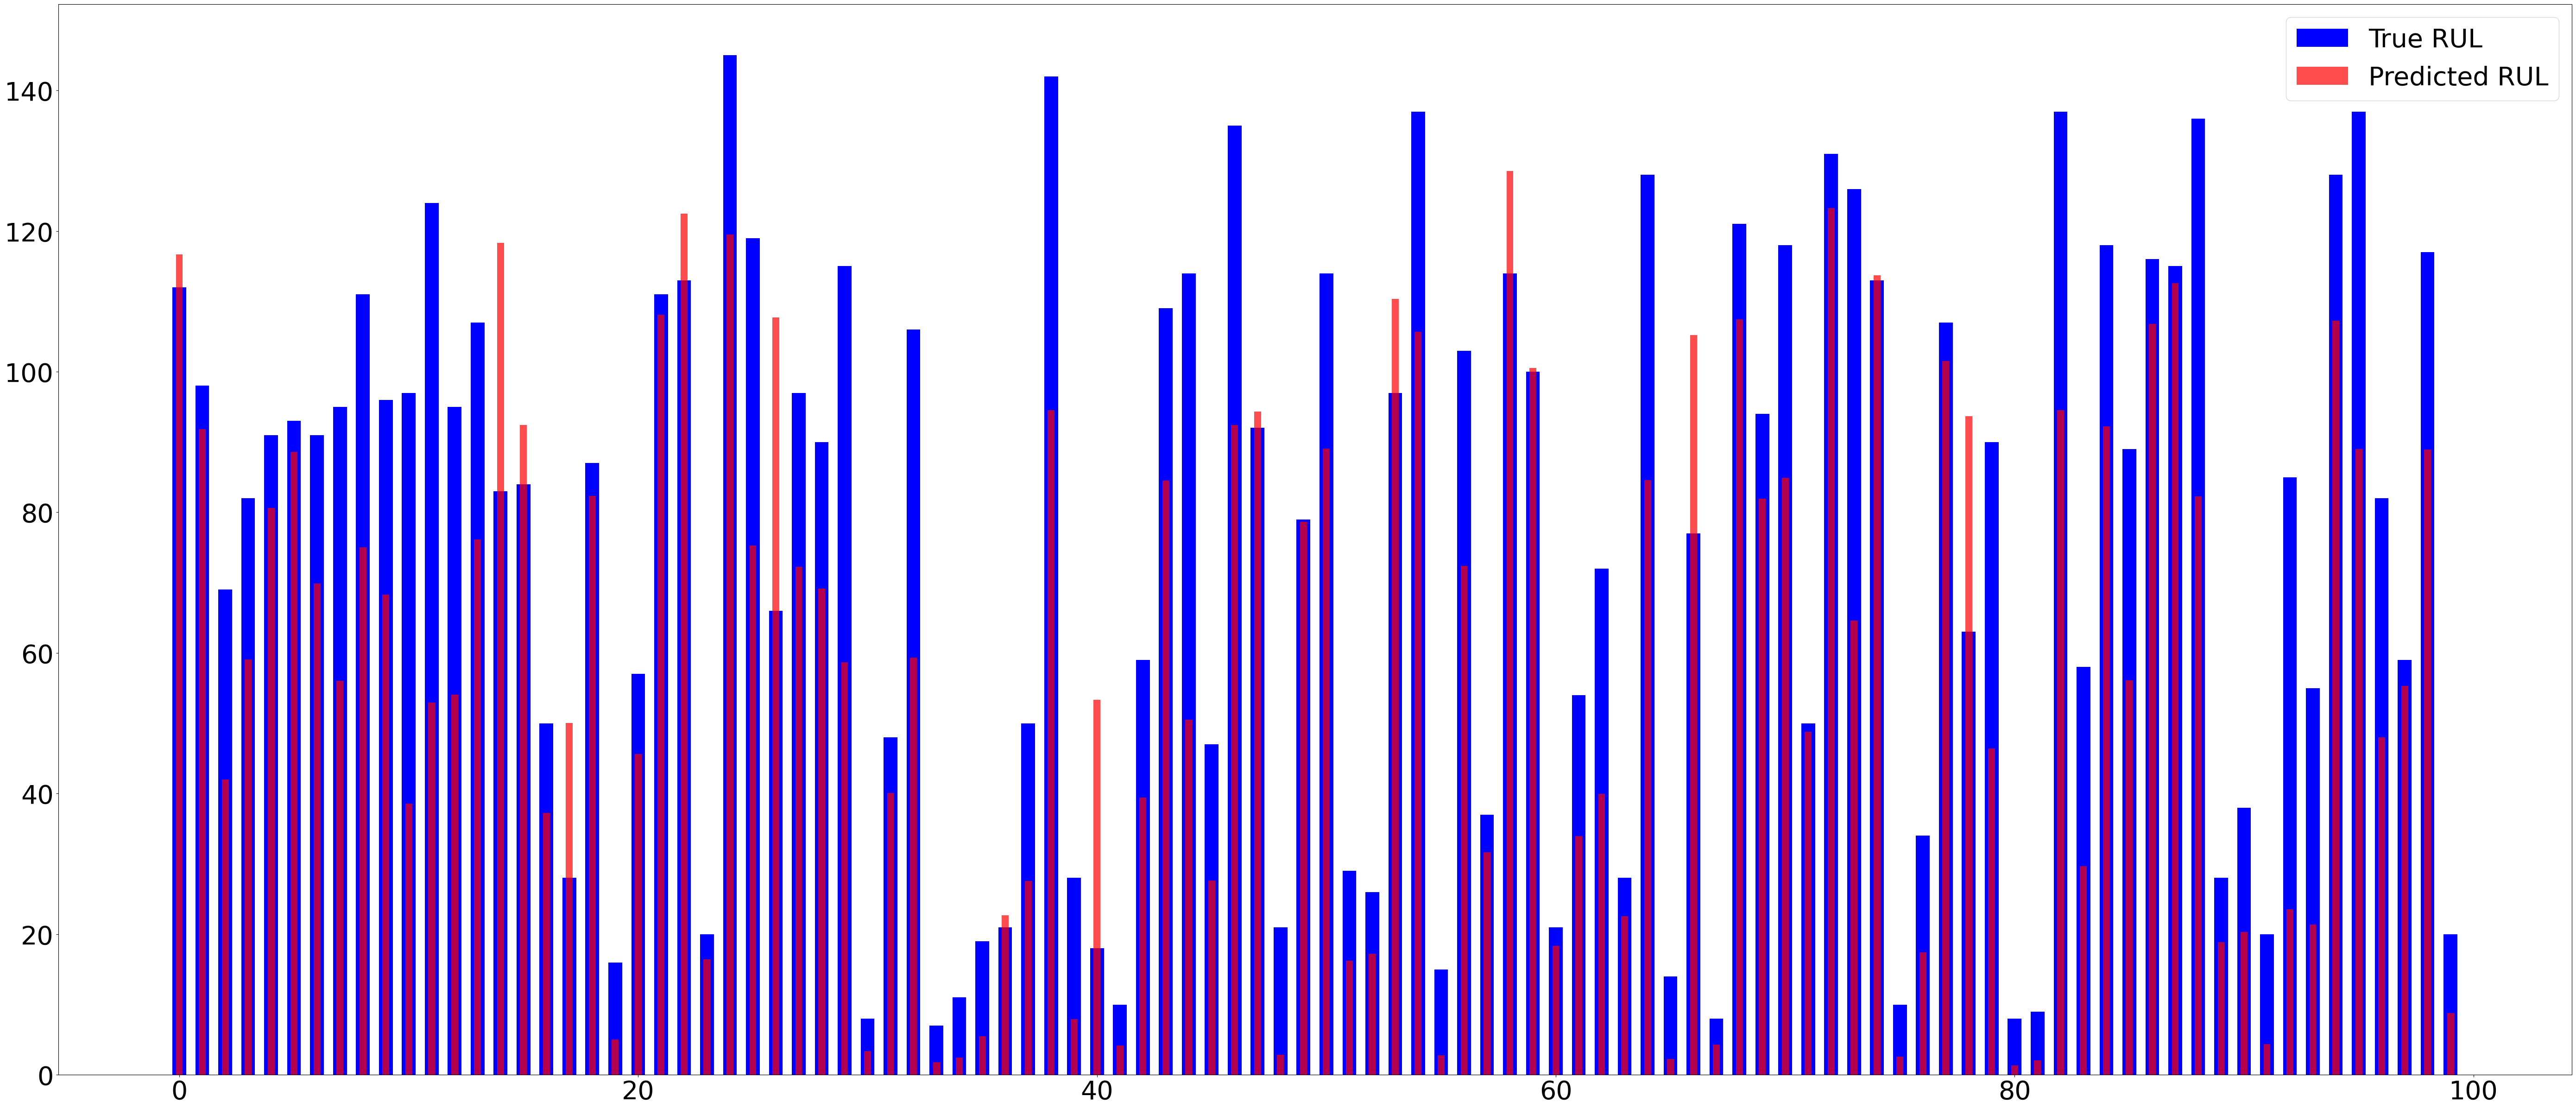

In [127]:
plot_predActual(y_valid, y_rf_valid)

### 3rd attempt (Data without useless sensors, with historical data)

In this section we are trying to discover a time series pattern in our features as we add to our data a new feature called 'rolling mean feature'. It's a equivalent to the mean value of a feature considering 10 time cycles. It will be computed for every feature.

In [43]:
df=train.copy()
for x in X_train_2.columns:
    df[x+'_rm']=0


df.columns

Index(['unit_number', 'time_cycles', 'setting_1', 'setting_2', 'setting_3',
       's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
       's_20', 's_21', 'RUL', 's_2_rm', 's_3_rm', 's_4_rm', 's_7_rm', 's_8_rm',
       's_9_rm', 's_11_rm', 's_12_rm', 's_13_rm', 's_14_rm', 's_15_rm',
       's_17_rm', 's_20_rm', 's_21_rm'],
      dtype='object')

In [44]:
drop_labels2=['s_1', 's_5','s_6','s_10',  's_16', 's_18', 's_19']
df=df.drop(columns=setting_names+drop_labels2+['RUL'], axis=1)

X_valid_3=valid.drop(columns=index_names+setting_names+drop_labels2, axis=1)

In [45]:
def update_rolling_mean(data, mask):
    for x, group in mask.groupby("unit_number"):
        for x in X_train_2.columns:
            data.loc[group.index[10:], x+"_rm"] = data.loc[group.index, x].rolling(10).mean()[10:]
            data.loc[group.index[:10], x+"_rm"] = data.loc[group.index[:10], x]

update_rolling_mean(df, df)
update_rolling_mean(X_valid_3, valid)

X_valid_3=X_valid_3.fillna(0)

dealing with last line problem

In [46]:
df.iloc[-1,-14:]=df.iloc[-2,-14:]
X_valid_3.iloc[-1,-14:]=X_valid_3.iloc[-2,-14:]

Saving the modified data-set.

In [47]:
train_tm=df

In [48]:
train_tm=train_tm.drop(columns=index_names, axis=1)

In [49]:
X_train_tm, X_test_tm, y_train_tm, y_test_tm=train_test_split(train_tm,train['RUL'].clip(upper=195), test_size=0.35, random_state=42)
X_train_tm_s=scaler.fit_transform(X_train_tm)
X_test_tm_s=scaler.fit_transform(X_test_tm)
X_val3=pd.concat([valid['unit_number'],X_valid_3],axis=1)
X_valid3 = X_val3.groupby('unit_number').last().reset_index().drop(columns=['unit_number'])
X_valid_s=scaler.fit_transform(X_valid3)

#### Models evaluation ( rmse, r2, features importance)

Linear regression

In [50]:
lr=Linear_Regression()
lr.fit(X_train_tm_s, y_train_tm)

y_lr_train = lr.predict(X_train_tm_s)
evaluate(y_train_tm,y_lr_train, label='train')

y_lr_test = lr.predict(X_test_tm_s)
evaluate(y_test_tm, y_lr_test, label='test')

y_lr_valid = lr.predict(X_valid_s)
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:40.529140113375824, R2:0.5544980153774888
test set RMSE:40.0989396737232, R2:0.5545324354987834
valid set RMSE:38.39141884713507, R2:0.14648967061777074


SVR

In [51]:
regressor.fit(X_train_tm_s, y_train_tm)

y_svr_train = regressor.predict(X_train_tm_s)
evaluate(y_train_tm,y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_tm_s)
evaluate(y_test_tm, y_svr_test, label='test')

y_svr_valid = regressor.predict(X_valid_s)
evaluate(y_valid, y_svr_valid, label='valid')

train set RMSE:32.48452364307428, R2:0.7138011601047023
test set RMSE:33.82872041899003, R2:0.6829546036019843
valid set RMSE:26.590317383722343, R2:0.5905626119267564


The model is generalized, we avoided overfitting

Random forest

In [52]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)
rf.fit(X_train_tm_s, y_train_tm)
# predict and evaluate
y_hat_train = rf.predict(X_train_tm_s)
evaluate(y_train_tm,y_hat_train, label='train')
y_hat_test = rf.predict(X_test_tm_s)
evaluate(y_test_tm, y_hat_test, label='test')
y_hat_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:9.787255139684294, R2:0.9740201473464815
test set RMSE:29.95828541820653, R2:0.7513524307207359
valid set RMSE:37.19248063789238, R2:0.19896637476274992


==> the model is overfitting to train/test

Performing Grid Search

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor()
param_grid = { 
    'n_estimators': [50,90,120],
    'max_depth' : [8,9,10],
}

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3)

grid.fit(X_train_tm_s, y_train_tm)

print(grid.best_score_ , grid.best_params_)
#max_features=5,

0.7860072617065642 {'max_depth': 10, 'n_estimators': 90}


In [54]:
rf=RandomForestRegressor(n_estimators=90,  max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train_tm_s, y_train_tm)
# predict and evaluate
y_hat_train = rf.predict(X_train_tm_s)
evaluate(y_train_tm,y_hat_train, label='train')
y_hat_test = rf.predict(X_test_tm_s)
evaluate(y_test_tm, y_hat_test, label='test')
y_hat_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:23.867485497289408, R2:0.8455001014801531
test set RMSE:30.15571767644218, R2:0.748064337874458
valid set RMSE:38.74817520895272, R2:0.1305532959618384


==> the model is overfitting to train/test

In [55]:
# Params found using Bayesian Optimisation
xgb = xgboost.XGBRegressor(n_estimators=50, 
                           max_depth=6,
                           learning_rate=0.1,
                           reg_lambda=0.02,
                           gamma=0.4,
                           random_state=42)
xgb.fit(X_train_tm_s, y_train_tm)

# predict and evaluate
y_hat_train = xgb.predict(X_train_tm_s)
evaluate(y_train_tm, y_hat_train, 'train')

y_hat_test = xgb.predict(X_test_tm_s)
evaluate(y_test_tm, y_hat_test)

y_hat_valid = xgb.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:24.299792748077127, R2:0.8398525592100936
test set RMSE:30.58551694695227, R2:0.7408316520739405
valid set RMSE:36.04940245429818, R2:0.24744785749198428


==> the model is overfitting to train/test

#### Cross Validation 

Cross validation will be performed with SVR model (best model so far) by performing multiple splits on the dataset and running the model on each proportion for every split

In [56]:
train_tm

s_2      s_3      s_4     s_7      s_8      s_9   s_11    s_12  \
0      641.82  1589.70  1400.60  554.36  2388.06  9046.19  47.47  521.66   
1      642.15  1591.82  1403.14  553.75  2388.04  9044.07  47.49  522.28   
2      642.35  1587.99  1404.20  554.26  2388.08  9052.94  47.27  522.42   
3      642.35  1582.79  1401.87  554.45  2388.11  9049.48  47.13  522.86   
4      642.37  1582.85  1406.22  554.00  2388.06  9055.15  47.28  522.19   
...       ...      ...      ...     ...      ...      ...    ...     ...   
20626  643.49  1597.98  1428.63  551.43  2388.19  9065.52  48.07  519.49   
20627  643.54  1604.50  1433.58  550.86  2388.23  9065.11  48.04  519.68   
20628  643.42  1602.46  1428.18  550.94  2388.24  9065.90  48.09  520.01   
20629  643.23  1605.26  1426.53  550.68  2388.25  9073.72  48.39  519.67   
20630  643.85  1600.38  1432.14  550.79  2388.26  9061.48  48.20  519.30   

          s_13     s_14  ...    s_8_rm    s_9_rm  s_11_rm  s_12_rm   s_13_rm  \
0      2388.02  8138.62  ...  2388.060  9046.190   47.470  521.660  2388.020   
1      2388.07  8131.49  ...  2388.040  9044.070   47.490  522.280  2388.070   
2      2388.03  8133.23  ...  2388.080  9052.940   47.270  522.420  2388.030   
3      2388.08  8133.83  ...  2388.110  9049.480   47.130  522.860  2388.080   
4      2388.04  8133.80  ...  2388.060  9055.150   47.280  522.190  2388.040   
...        ...      ...  ...       ...       ...      ...      ...       ...   
20626  2388.26  8137.60  ...  2388.224  9066.903   48.116  519.840  2388.237   
20627  2388.22  8136.50  ...  2388.225  9066.820   48.116  519.793  2388.237   
20628  2388.24  8141.05  ...  2388.223  9066.642   48.096  519.796  2388.240   
20629  2388.23  8139.29  ...  2388.230  9067.045   48.136  519.813  2388.239   
20630  2388.26  8137.33  ...  2388.230  9067.045   48.136  519.813  2388.239   

        s_14_rm  s_15_rm  s_17_rm  s_20_rm   s_21_rm  
0      8138.620  8.41950    392.0   39.060  23.41900  
1      8131.490  8.43180    392.0   39.000  23.42360  
2      8133.230  8.41780    390.0   38.950  23.34420  
3      8133.830  8.36820    392.0   38.880  23.37390  
4      8133.800  8.42940    393.0   38.900  23.40440  
...         ...      ...      ...      ...       ...  
20626  8141.170  8.51031    396.0   38.453  23.09254  
20627  8140.771  8.51083    395.9   38.416  23.08540  
20628  8140.882  8.51915    396.2   38.424  23.07321  
20629  8140.833  8.52434    396.0   38.388  23.07370  
20630  8140.833  8.52434    396.0   38.388  23.07370  

[20631 rows x 28 columns]

In [57]:
from sklearn.model_selection import KFold
train_tm_cv=train_tm.copy()
y=train['RUL'].clip(upper=195)
scores_train=[]
scores_test=[]
scores_validation=[]

cv = KFold(n_splits=4, shuffle=True)
for train_index, test_index in cv.split(train_tm) :
    print("Index du train : ", train_index, "\n")
    print("Index de test : ", test_index)
    X_train, X_test, y_train, y_test = train_tm.iloc[train_index,:], train_tm.iloc[test_index,:],y[train_index], y[test_index]
    regressor.fit(scaler.fit_transform(X_train), y_train)
    y_hat_train = regressor.predict(scaler.fit_transform(X_train))
    evaluate(y_train,y_hat_train, label='train')
    y_hat_test = regressor.predict(scaler.fit_transform(X_test))
    evaluate(y_test, y_hat_test, label='test')
    y_hat_valid = regressor.predict(scaler.fit_transform(X_valid3))
    evaluate(y_valid, y_hat_valid, label='valid')



Index du train :  [    0     1     2 ... 20628 20629 20630] 

Index de test :  [    4     6     8 ... 20611 20615 20625]
train set RMSE:32.49687359906522, R2:0.7116289227935093
test set RMSE:32.493781013218545, R2:0.7110055673383389
valid set RMSE:27.689283640034333, R2:0.5560194999678765
Index du train :  [    1     2     3 ... 20628 20629 20630] 

Index de test :  [    0     7     9 ... 20620 20622 20627]
train set RMSE:32.34840471860422, R2:0.7138289768429971
test set RMSE:32.97829395834572, R2:0.7035595458292802
valid set RMSE:27.668648696844684, R2:0.5566809904410818
Index du train :  [    0     1     2 ... 20628 20629 20630] 

Index de test :  [    3     5    10 ... 20623 20624 20626]
train set RMSE:32.46821119033224, R2:0.7134634118010157
test set RMSE:32.56920407819318, R2:0.7055759767955598
valid set RMSE:27.99351581966008, R2:0.5462095528547383
Index du train :  [    0     3     4 ... 20625 20626 20627] 

Index de test :  [    1     2    13 ... 20628 20629 20630]
train set RM

### feature importance

<BarContainer object of 28 artists>

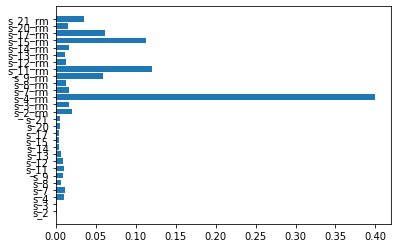

In [58]:
#BEST FEATURE FOR XGB MODEL
xgb.fit(X_train_tm_s, y_train_tm)
plt.barh(train_tm.columns, xgb.feature_importances_)

<BarContainer object of 28 artists>

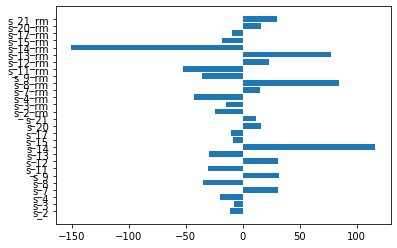

In [59]:
#BEST FEATURE FOR LINEAR REGRESSION MODEL

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X=X_train_tm_s, y=y_train_tm)
plt.barh(X_train_tm.columns, model.coef_)

<BarContainer object of 28 artists>

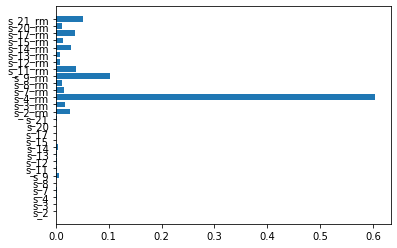

In [60]:
#BEST FEATURE FOR RF MODEL
rf.fit(X_train_tm_s, y_train_tm)
plt.barh(train_tm.columns, rf.feature_importances_)

#### Creating new df

In [61]:
dftm= pd.concat([train['unit_number'],train_tm,train['RUL']],axis=1)

In [62]:
dftm

unit_number     s_2      s_3      s_4     s_7      s_8      s_9   s_11  \
0                1  641.82  1589.70  1400.60  554.36  2388.06  9046.19  47.47   
1                1  642.15  1591.82  1403.14  553.75  2388.04  9044.07  47.49   
2                1  642.35  1587.99  1404.20  554.26  2388.08  9052.94  47.27   
3                1  642.35  1582.79  1401.87  554.45  2388.11  9049.48  47.13   
4                1  642.37  1582.85  1406.22  554.00  2388.06  9055.15  47.28   
...            ...     ...      ...      ...     ...      ...      ...    ...   
20626          100  643.49  1597.98  1428.63  551.43  2388.19  9065.52  48.07   
20627          100  643.54  1604.50  1433.58  550.86  2388.23  9065.11  48.04   
20628          100  643.42  1602.46  1428.18  550.94  2388.24  9065.90  48.09   
20629          100  643.23  1605.26  1426.53  550.68  2388.25  9073.72  48.39   
20630          100  643.85  1600.38  1432.14  550.79  2388.26  9061.48  48.20   

         s_12     s_13  ...    s_9_rm  s_11_rm  s_12_rm   s_13_rm   s_14_rm  \
0      521.66  2388.02  ...  9046.190   47.470  521.660  2388.020  8138.620   
1      522.28  2388.07  ...  9044.070   47.490  522.280  2388.070  8131.490   
2      522.42  2388.03  ...  9052.940   47.270  522.420  2388.030  8133.230   
3      522.86  2388.08  ...  9049.480   47.130  522.860  2388.080  8133.830   
4      522.19  2388.04  ...  9055.150   47.280  522.190  2388.040  8133.800   
...       ...      ...  ...       ...      ...      ...       ...       ...   
20626  519.49  2388.26  ...  9066.903   48.116  519.840  2388.237  8141.170   
20627  519.68  2388.22  ...  9066.820   48.116  519.793  2388.237  8140.771   
20628  520.01  2388.24  ...  9066.642   48.096  519.796  2388.240  8140.882   
20629  519.67  2388.23  ...  9067.045   48.136  519.813  2388.239  8140.833   
20630  519.30  2388.26  ...  9067.045   48.136  519.813  2388.239  8140.833   

       s_15_rm  s_17_rm  s_20_rm   s_21_rm  RUL  
0      8.41950    392.0   39.060  23.41900  191  
1      8.43180    392.0   39.000  23.42360  190  
2      8.41780    390.0   38.950  23.34420  189  
3      8.36820    392.0   38.880  23.37390  188  
4      8.42940    393.0   38.900  23.40440  187  
...        ...      ...      ...       ...  ...  
20626  8.51031    396.0   38.453  23.09254    4  
20627  8.51083    395.9   38.416  23.08540    3  
20628  8.51915    396.2   38.424  23.07321    2  
20629  8.52434    396.0   38.388  23.07370    1  
20630  8.52434    396.0   38.388  23.07370    0  

[20631 rows x 30 columns]

Plotting new features 

In [63]:
def plot_signal(df, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):  
            plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(8).mean())

    plt.ylabel(signal_name)
    plt.xlabel('Remaining Useful Life')
    plt.show()



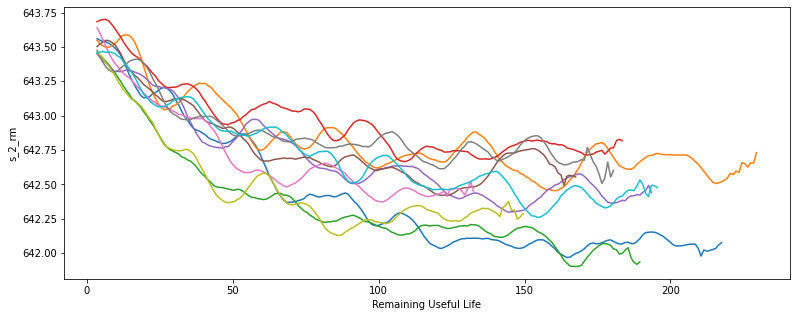

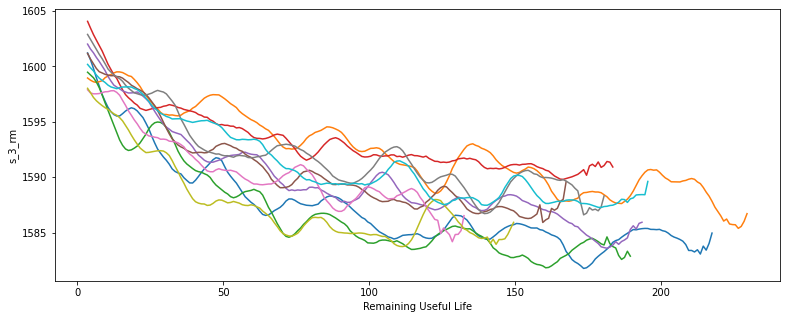

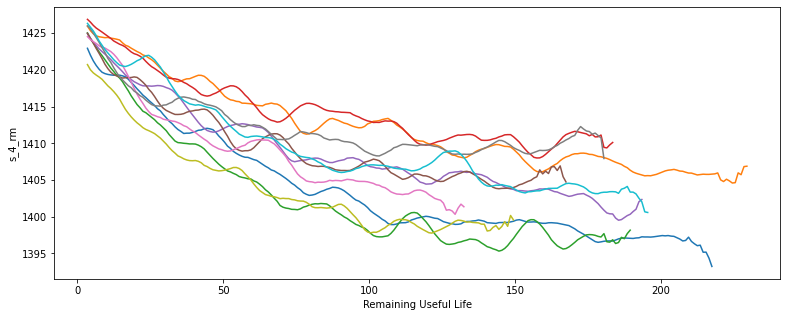

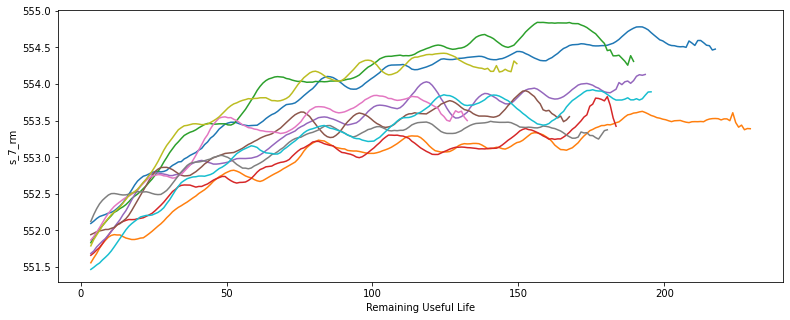

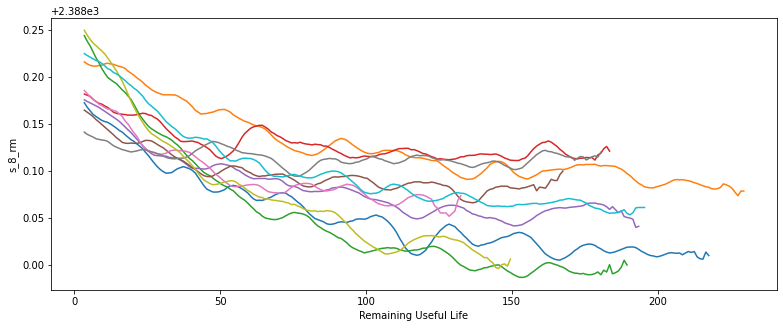

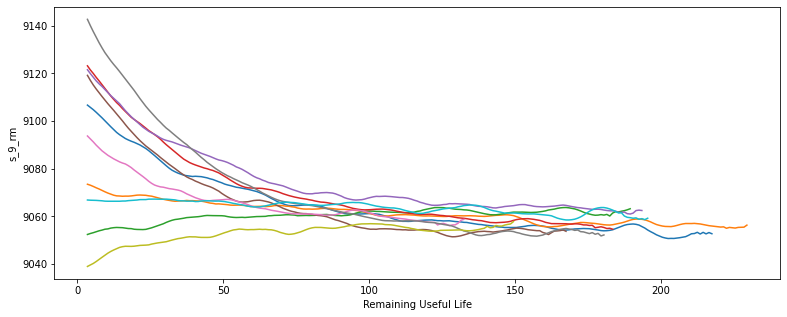

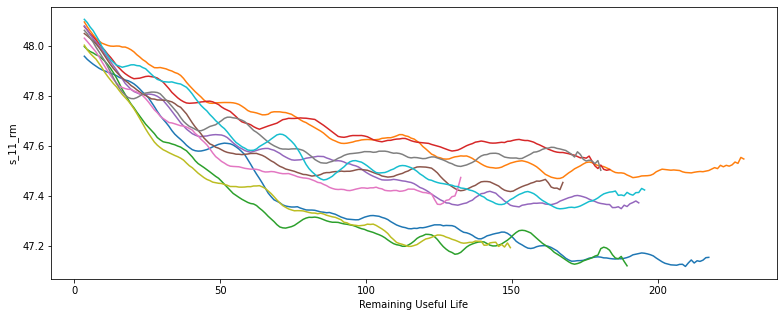

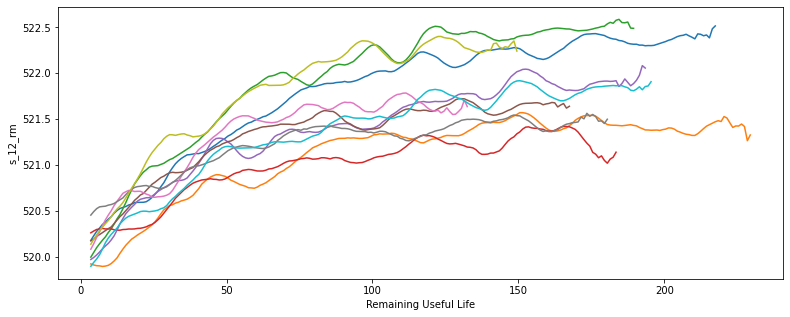

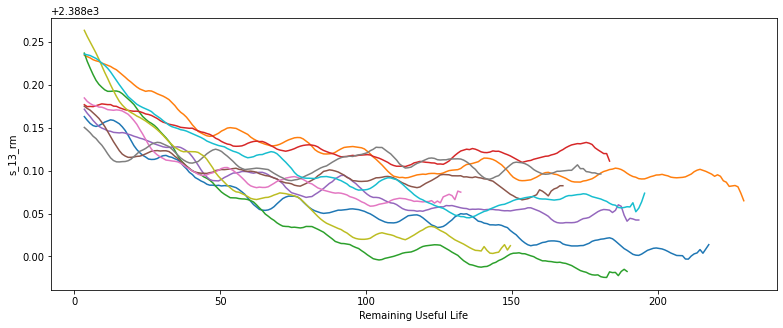

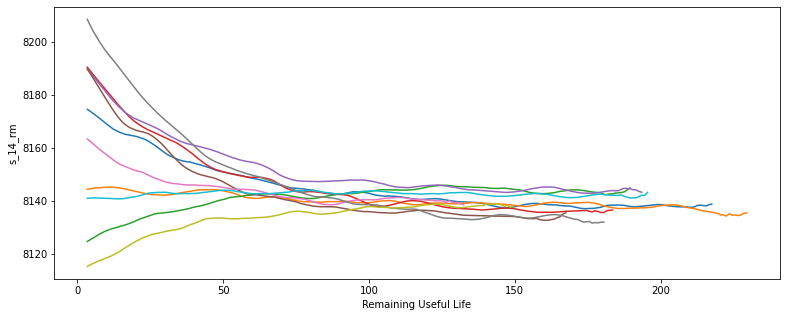

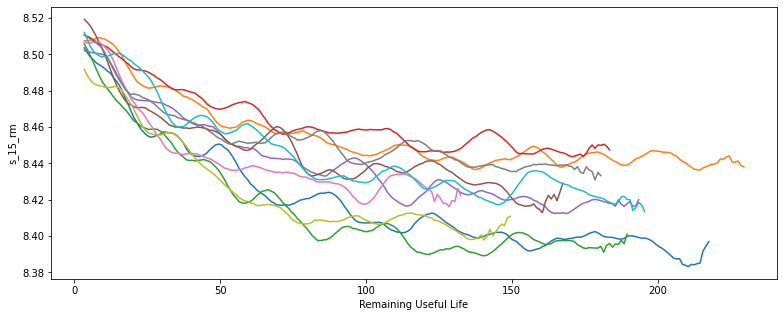

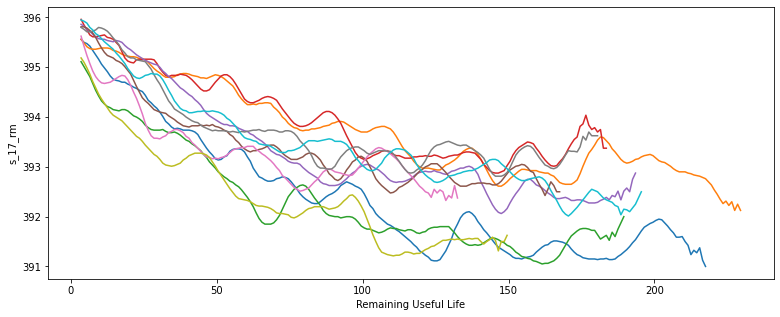

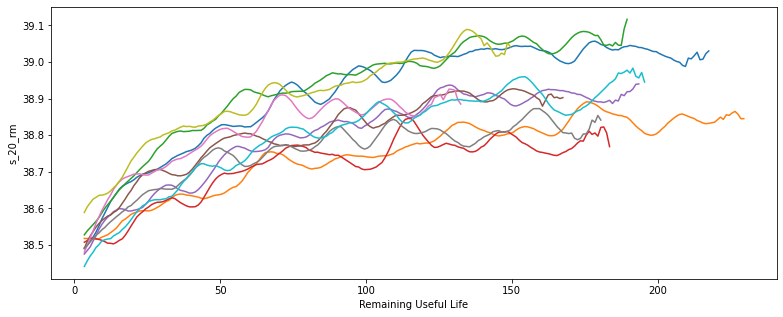

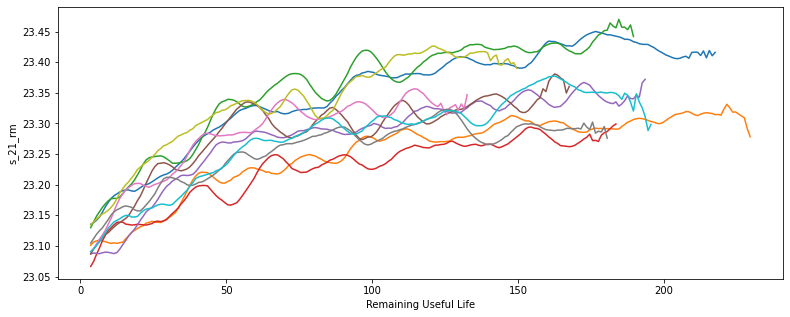

In [64]:
for i in range(1,22):
     if i not in [1,5,6,10,16,18,19] :
        try:
            plot_signal(dftm, 's_'+str(i)+'_rm')
        except:
            pass

### 

What we are seeing here is that sensors s_9, s_11, s_12 et s_7 have a significant effect on RUL.
For instance, if keep all other features constant, we notice that when the Physical core speed (represented by s_9) increases , the RUL is comparatively decreasing.

### Best Model

Judging by the difference in RMSE, we notice that SVR performs better than the other models when executed on the whole dataset.
The test RMSE obtained is 31, which will be our score to beat while running the model on the best features found so far. 

### Classification (diviser les valeurs de rul en classes)
- balanced data (2 classes / 3 classes  / 4 classes) binning
-models : random forest, svc, naive bayes, knn
- evaluation : confusion matrix, recall


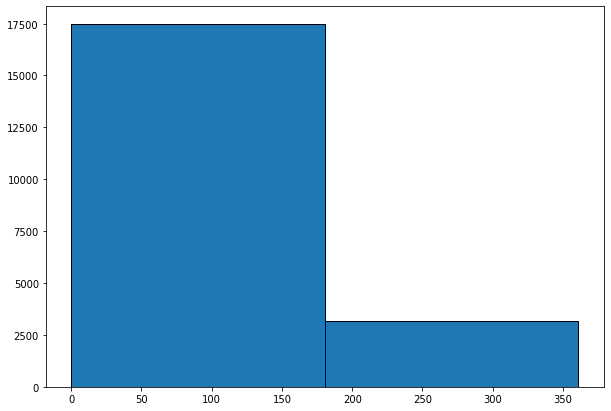

(array([17462.,  3169.]), array([  0. , 180.5, 361. ]), <BarContainer object of 2 artists>)


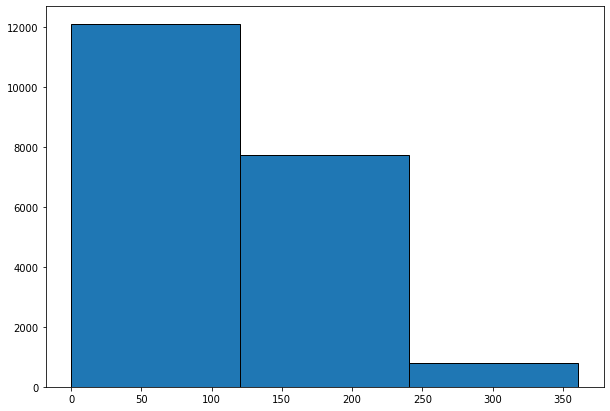

(array([12100.,  7735.,   796.]), array([  0.        , 120.33333333, 240.66666667, 361.        ]), <BarContainer object of 3 artists>)


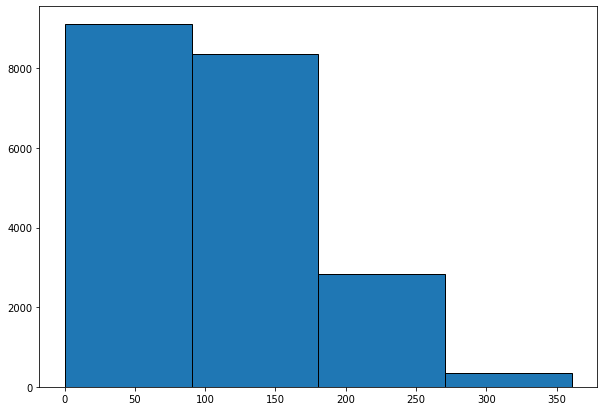

(array([9100., 8362., 2823.,  346.]), array([  0.  ,  90.25, 180.5 , 270.75, 361.  ]), <BarContainer object of 4 artists>)


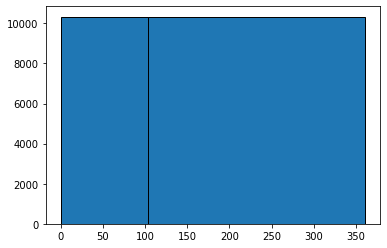

[  0. 103. 361.]


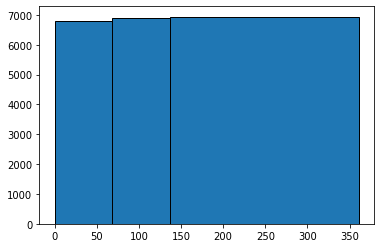

[  0.  68. 137. 361.]


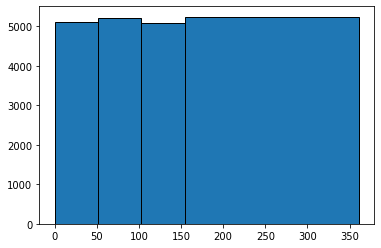

[  0.  51. 103. 155. 361.]


In [65]:
#-- fixing bins width -----
# Creating histogram of 2 bins(same width)
fig, ax = plt.subplots(figsize =(10, 7))
m=ax.hist(list(train['RUL']), bins = 2, edgecolor='black')
# Show plot
plt.show()
print(m)

# Creating histogram of 3 bins(same width)
fig, ax = plt.subplots(figsize =(10, 7))
m=ax.hist(list(train['RUL']), bins = 3, edgecolor='black')
# Show plot
plt.show()
print(m)

# Creating histogram of 4 bins(same width)
fig, ax = plt.subplots(figsize =(10, 7))
m=ax.hist(list(train['RUL']), bins = 4, edgecolor='black')
# Show plot
plt.show()
print(m)



#-- fixing bins height -----

l=len(list(train['RUL']))
k=l/4

#define function to calculate equal-frequency bins, bins=2
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

#create histogram with equal-frequency bins 
n, bins, patches = plt.hist(list(train['RUL']), equalObs(list(train['RUL']), 2), edgecolor='black')
plt.show()
print(bins)

#define function to calculate equal-frequency bins, bins=3
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

#create histogram with equal-frequency bins 
n, bins, patches = plt.hist(list(train['RUL']), equalObs(list(train['RUL']), 3), edgecolor='black')
plt.show()
print(bins)


#define function to calculate equal-frequency bins, bins=4
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

#create histogram with equal-frequency bins 
n, bins, patches = plt.hist(list(train['RUL']), equalObs(list(train['RUL']), 4), edgecolor='black')
plt.show()
print(bins)



####  Binning outcome demonstrated that we can create classes of RUL and turn our problem to a classification problem.
##### The priority will be given for bins that give us balanced classes
###### Let's suppose we have 3 classes of RUL 
- 1 for RUL in [0..68]    : RISK ZONE
- 2 for RUL in [69..137]  : MODERATED RISK
- 3 for RUL in [138..361] : NO RISK

##### ! Notice :  We will be working with last version of data the containing historical data (moving average) with some dropped sensors.

#### Data preparation for classification

In [66]:
y_train_tm

12276     30
8157      80
11666    103
12639    124
5278      30
        ... 
11284    107
11964    162
5390      74
860      195
15795    157
Name: RUL, Length: 13410, dtype: int64

In [67]:

label_map={1:"RISK ZONE",2:"MODERATED RISK",3:"NO RISK"}

y=[]

#--Transforming rul values to classes :
for k in dftm['RUL']:
    if k<=68:
        y.append(1)
    elif k>69 and k<=137:
        y.append(2)
    else:
        y.append(3)
X_train_tm_c, X_test_tm_c, y_train_tm_c, y_test_tm_c=train_test_split(dftm.drop(columns=['unit_number','RUL']),np.array(y), test_size=0.35, stratify=np.array(y))
X_train_tm_cs=scaler.fit_transform(X_train_tm_c)
X_test_tm_cs=scaler.fit_transform(X_test_tm_c)


#### Defining evaluation function

In [68]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true)))

#### Models Implementation

In [69]:
# Fit du  Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear',random_state = 1)

#### Random forest 

In [70]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#### Models evaluation

In [71]:
y_valid_c=[]
for k in y_valid['RUL']:
    if k<=68:
        y_valid_c.append(1)
    elif k>69 and k<=137:
        y_valid_c.append(2)
    else:
        y_valid_c.append(3)
        
y_valid_c=np.array(y_valid_c)

### SVC

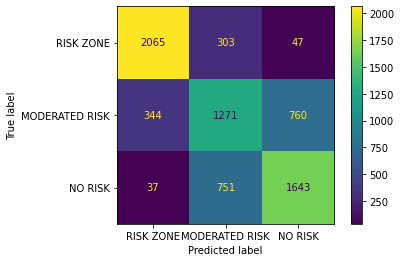

SVM
Accuracy score of training 0.685
Error rate of training 0.176
Accuracy score of test 0.690
Error rate of test 0.170
              precision    recall  f1-score   support

           1       0.84      0.86      0.85      2415
           2       0.55      0.54      0.54      2375
           3       0.67      0.68      0.67      2431

    accuracy                           0.69      7221
   macro avg       0.69      0.69      0.69      7221
weighted avg       0.69      0.69      0.69      7221



In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

classifier.fit(X_train_tm_cs,np.array(y_train_tm_c))
y_svc_train=classifier.predict(X_train_tm_cs)

y_svc_test=classifier.predict(X_test_tm_cs)


cm= confusion_matrix(y_test_tm_c, y_svc_test, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[classifier.classes_[0]],label_map[classifier.classes_[1]],label_map[classifier.classes_[2]]])
disp.plot()
plt.show()

# Measure the performance
print('SVM')
print("Accuracy score of training %.3f" %metrics.accuracy_score(y_train_tm_c, y_svc_train))
print("Error rate of training %.3f" %mean_absolute_percentage_error(y_train_tm_c,y_svc_train))
print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test_tm_c, y_svc_test))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test_tm_c,y_svc_test))
print(metrics.classification_report(y_test_tm_c,y_svc_test))

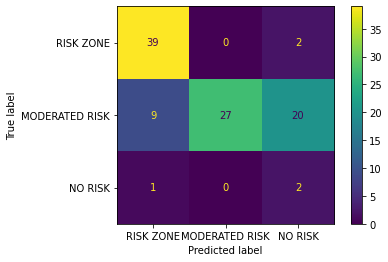

SVM
Accuracy score of validation 0.680
Error rate of validation 0.192


In [73]:
y_svc_valid=classifier.predict(X_valid_s)
cm= confusion_matrix(y_valid_c, y_svc_valid, labels=classifier.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[classifier.classes_[0]],label_map[classifier.classes_[1]],label_map[classifier.classes_[2]]])
disp.plot()
plt.show()
print('SVM')
print("Accuracy score of validation %.3f" %metrics.accuracy_score(y_valid_c,  y_svc_valid))
print("Error rate of validation %.3f" %mean_absolute_percentage_error(y_valid_c, y_svc_valid))

### Random Forest Classifier

In [74]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=5)

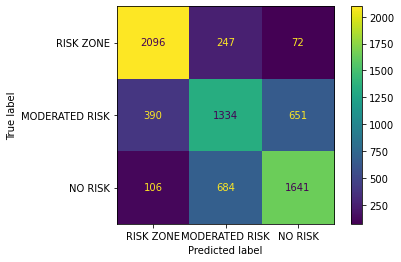

Random Forest Classifier
Accuracy score of test 0.973
Error rate of test 0.015
Accuracy score of test 0.702
Error rate of test 0.168
              precision    recall  f1-score   support

           1       0.81      0.87      0.84      2415
           2       0.59      0.56      0.58      2375
           3       0.69      0.68      0.68      2431

    accuracy                           0.70      7221
   macro avg       0.70      0.70      0.70      7221
weighted avg       0.70      0.70      0.70      7221



In [75]:
clf.fit(X_train_tm_cs,np.array(y_train_tm_c))
y_rfc_train=clf.predict(X_train_tm_cs)
y_rfc_test=clf.predict(X_test_tm_cs)
cm= confusion_matrix(y_test_tm_c, y_rfc_test, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[clf.classes_[0]],label_map[clf.classes_[1]],label_map[clf.classes_[2]]])
disp.plot()
plt.show()

# Measure the performance
print('Random Forest Classifier')
print("Accuracy score of test %.3f" %metrics.accuracy_score(y_train_tm_c, y_rfc_train))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_train_tm_c,y_rfc_train))

print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test_tm_c, y_rfc_test))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test_tm_c,y_rfc_test))

print(metrics.classification_report(y_test_tm_c,y_rfc_test))

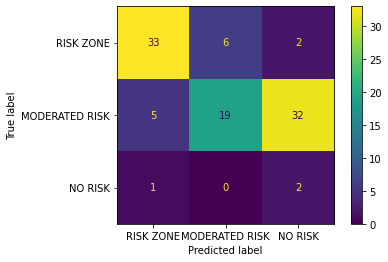

Random Forest Classifier
Accuracy score of validation 0.540
Error rate of validation 0.292
              precision    recall  f1-score   support

           1       0.85      0.80      0.83        41
           2       0.76      0.34      0.47        56
           3       0.06      0.67      0.10         3

    accuracy                           0.54       100
   macro avg       0.55      0.60      0.47       100
weighted avg       0.77      0.54      0.60       100



In [76]:
y_rfc_valid=clf.predict(X_valid_s)
cm= confusion_matrix(y_valid_c, y_rfc_valid, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[clf.classes_[0]],label_map[clf.classes_[1]],label_map[clf.classes_[2]]])
disp.plot()
plt.show()
print('Random Forest Classifier')
print("Accuracy score of validation %.3f" %metrics.accuracy_score(y_valid_c, y_rfc_valid))
print("Error rate of validation %.3f" %mean_absolute_percentage_error(y_valid_c,y_rfc_valid))
print(metrics.classification_report(y_valid_c,y_rfc_valid))

### Naive bayes

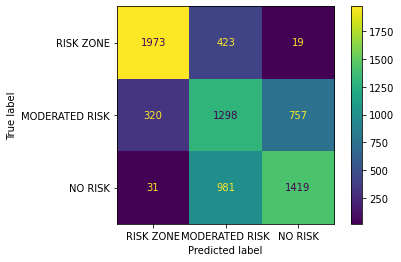

Guassian Naive Bayes
Accuracy score of train 0.634
Error rate of train 0.198
Accuracy score of test 0.649
Error rate of test 0.187
              precision    recall  f1-score   support

           1       0.85      0.82      0.83      2415
           2       0.48      0.55      0.51      2375
           3       0.65      0.58      0.61      2431

    accuracy                           0.65      7221
   macro avg       0.66      0.65      0.65      7221
weighted avg       0.66      0.65      0.65      7221



In [77]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_tm_cs,np.array(y_train_tm_c))

y_gnb_test= gnb.predict(X_test_tm_cs)
y_gnb_train= gnb.predict(X_train_tm_cs)


cm= confusion_matrix(y_test_tm_c, y_gnb_test, labels=gnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[gnb.classes_[0]],label_map[gnb.classes_[1]],label_map[gnb.classes_[2]]])
disp.plot()
plt.show()

# Measure the performance
print('Guassian Naive Bayes')
print("Accuracy score of train %.3f" %metrics.accuracy_score(y_train_tm_c, y_gnb_train))
print("Error rate of train %.3f" %mean_absolute_percentage_error(y_train_tm_c,y_gnb_train))
print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test_tm_c, y_gnb_test))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test_tm_c,y_gnb_test))

print(metrics.classification_report(y_test_tm_c,y_gnb_test))

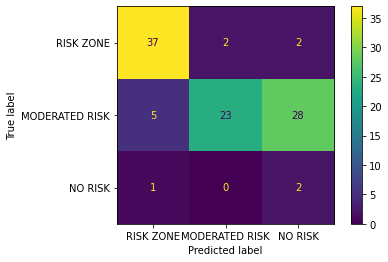

Random Forest Classifier
Accuracy score of validation 0.620
Error rate of validation 0.232
              precision    recall  f1-score   support

           1       0.86      0.90      0.88        41
           2       0.92      0.41      0.57        56
           3       0.06      0.67      0.11         3

    accuracy                           0.62       100
   macro avg       0.61      0.66      0.52       100
weighted avg       0.87      0.62      0.68       100



In [78]:
y_gnb_valid=gnb.predict(X_valid_s)
cm= confusion_matrix(y_valid_c, y_gnb_valid, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[gnb.classes_[0]],label_map[gnb.classes_[1]],label_map[gnb.classes_[2]]])
disp.plot()
plt.show()
print('Random Forest Classifier')
print("Accuracy score of validation %.3f" %metrics.accuracy_score(y_valid_c, y_gnb_valid))
print("Error rate of validation %.3f" %mean_absolute_percentage_error(y_valid_c,y_gnb_valid))
print(metrics.classification_report(y_valid_c,y_gnb_valid))


### KNN

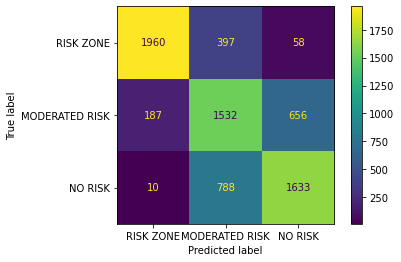

KNN
Accuracy score of train 0.721
Error rate of train 0.167
Accuracy score of test 0.710
Error rate of test 0.167
              precision    recall  f1-score   support

           1       0.91      0.81      0.86      2415
           2       0.56      0.65      0.60      2375
           3       0.70      0.67      0.68      2431

    accuracy                           0.71      7221
   macro avg       0.72      0.71      0.71      7221
weighted avg       0.72      0.71      0.71      7221



In [79]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train_tm_cs,np.array(y_train_tm_c))

y_knn_test= knn.predict(X_test_tm_cs)
y_knn_train= knn.predict(X_train_tm_cs)

cm= confusion_matrix(y_test_tm_c, y_knn_test, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[knn.classes_[0]],label_map[knn.classes_[1]],label_map[knn.classes_[2]]])
disp.plot()
plt.show()

# Measure the performance
print('KNN')
print("Accuracy score of train %.3f" %metrics.accuracy_score(y_train_tm_c, y_knn_train))
print("Error rate of train %.3f" %mean_absolute_percentage_error(y_train_tm_c,y_knn_train))
print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test_tm_c, y_knn_test))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test_tm_c,y_knn_test))

print(metrics.classification_report(y_test_tm_c,y_knn_test))

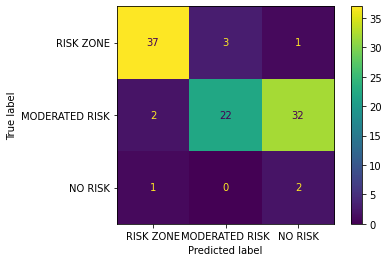

KNN
Accuracy score of validation 0.610
Error rate of validation 0.227
              precision    recall  f1-score   support

           1       0.93      0.90      0.91        41
           2       0.88      0.39      0.54        56
           3       0.06      0.67      0.11         3

    accuracy                           0.61       100
   macro avg       0.62      0.65      0.52       100
weighted avg       0.87      0.61      0.68       100



In [80]:
y_knn_valid=knn.predict(X_valid_s)
cm= confusion_matrix(y_valid_c, y_knn_valid, labels=knn.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[knn.classes_[0]],label_map[knn.classes_[1]],label_map[knn.classes_[2]]])
disp.plot()
plt.show()
print('KNN')
print("Accuracy score of validation %.3f" %metrics.accuracy_score(y_valid_c, y_knn_valid))
print("Error rate of validation %.3f" %mean_absolute_percentage_error(y_valid_c,y_knn_valid))
print(metrics.classification_report(y_valid_c,y_knn_valid))


Running cross validation on SVC (best model so far)

In [81]:
def transform_to_classes(d):
    y=[]
    for k in d:
        if k<=68:
            y.append(1)
        elif k>69 and k<=137:
            y.append(2)
        else:
            y.append(3)
    return y

Index du train :  [    0     1     2 ... 20627 20628 20629] 

Index de test :  [    3    11    17 ... 20597 20606 20630]


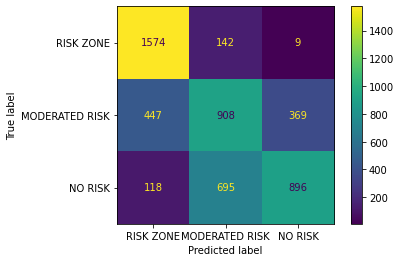

SVM
Accuracy score of training 0.689
Error rate of training 0.174
Accuracy score of test 0.655
Error rate of test 0.170
              precision    recall  f1-score   support

           1       0.74      0.91      0.81      1725
           2       0.52      0.53      0.52      1724
           3       0.70      0.52      0.60      1709

    accuracy                           0.65      5158
   macro avg       0.65      0.65      0.65      5158
weighted avg       0.65      0.65      0.65      5158

Index du train :  [    0     3     4 ... 20627 20628 20630] 

Index de test :  [    1     2     6 ... 20625 20626 20629]


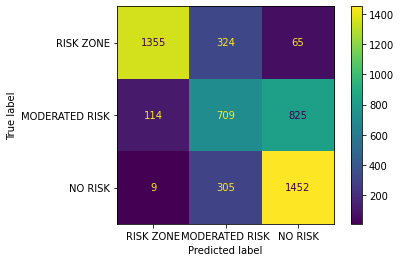

SVM
Accuracy score of training 0.688
Error rate of training 0.174
Accuracy score of test 0.682
Error rate of test 0.200
              precision    recall  f1-score   support

           1       0.92      0.78      0.84      1744
           2       0.53      0.43      0.47      1648
           3       0.62      0.82      0.71      1766

    accuracy                           0.68      5158
   macro avg       0.69      0.68      0.67      5158
weighted avg       0.69      0.68      0.68      5158

Index du train :  [    1     2     3 ... 20628 20629 20630] 

Index de test :  [    0    14    18 ... 20619 20622 20624]


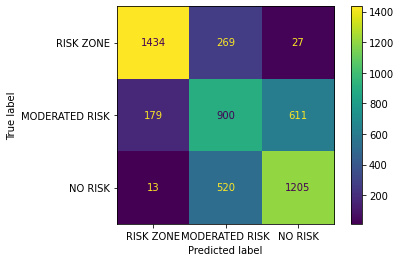

SVM
Accuracy score of training 0.689
Error rate of training 0.174
Accuracy score of test 0.686
Error rate of test 0.174
              precision    recall  f1-score   support

           1       0.88      0.83      0.85      1730
           2       0.53      0.53      0.53      1690
           3       0.65      0.69      0.67      1738

    accuracy                           0.69      5158
   macro avg       0.69      0.68      0.69      5158
weighted avg       0.69      0.69      0.69      5158

Index du train :  [    0     1     2 ... 20626 20629 20630] 

Index de test :  [    4     5     7 ... 20623 20627 20628]


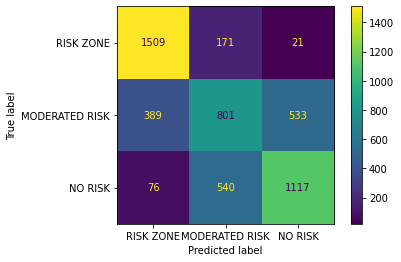

SVM
Accuracy score of training 0.688
Error rate of training 0.175
Accuracy score of test 0.665
Error rate of test 0.175
              precision    recall  f1-score   support

           1       0.76      0.89      0.82      1701
           2       0.53      0.46      0.50      1723
           3       0.67      0.64      0.66      1733

    accuracy                           0.66      5157
   macro avg       0.65      0.67      0.66      5157
weighted avg       0.65      0.66      0.66      5157



In [82]:
from sklearn.model_selection import KFold
train_tm_cv=dftm.drop(columns=['unit_number','RUL']).copy()
y=dftm['RUL']
cv = KFold(n_splits=4, shuffle=True)
for train_index, test_index in cv.split(train_tm) :
    print("Index du train : ", train_index, "\n")
    print("Index de test : ", test_index)
    X_train, X_test, y_train, y_test = train_tm_cv.iloc[train_index,:], train_tm_cv.iloc[test_index,:],np.array(transform_to_classes(y[train_index])), np.array(transform_to_classes(y[test_index]))
    classifier.fit(scaler.fit_transform(X_train), y_train)
    y_svc_train=classifier.predict(scaler.fit_transform(X_train))

    y_svc_test=classifier.predict(scaler.fit_transform(X_test))


    cm= confusion_matrix(y_test, y_svc_test, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[classifier.classes_[0]],label_map[classifier.classes_[1]],label_map[classifier.classes_[2]]])
    disp.plot()
    plt.show()

    # Measure the performance
    print('SVM')
    print("Accuracy score of training %.3f" %metrics.accuracy_score(y_train, y_svc_train))
    print("Error rate of training %.3f" %mean_absolute_percentage_error(y_train,y_svc_train))
    print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test, y_svc_test))
    print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test,y_svc_test))
    print(metrics.classification_report(y_test,y_svc_test))

Hence, SVR has appeared to be the best model.